In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from os.path import join as pjoin
from functools import partial
from tqdm import tqdm
from IPython.core.display import Image, display

In [2]:
gen_img_path = None
def generator(path,
              size=256,
              is_test=False):
    global gen_img_path
    image_paths = [pjoin(path, img_path) for img_path in os.listdir(path)]
    img_path = random.choice(image_paths)
    gen_img_path = img_path
    img = cv2.imread(img_path, 0) #read grayscale
    img = cv2.resize(img, (size, size))
    img = 2*img/255 - 1
    while 1:
#         i, j = random.choice(list(range(size//crop_size))), random.choice(list(range(size//crop_size)))
#         x = img[i*crop_size: (i+1)*crop_size, j*crop_size: (j+1)*crop_size].flatten()
#         left = random.randrange(size - crop_size)
#         top = random.randrange(size - crop_size)
#         x = img[top:top+crop_size, left:left+crop_size].flatten()
        
        #assert(x.shape[0] == (crop_size)**2)
        
        yield img.copy()
            

In [3]:
def generator2(path,
              size=256,
              crop_size=16,
              is_test=False):
    images = [cv2.resize(cv2.imread(pjoin(path, img_path), 0), (size, size)) for img_path in tqdm(os.listdir(path))]
    while 1:
        img = random.choice(images)
        img = 2*img/255 - 1
        yield img
        #i, j = random.choice(list(range(size//crop_size))), random.choice(list(range(size//crop_size)))
        #x = img[i*crop_size: (i+1)*crop_size, j*crop_size: (j+1)*crop_size].flatten()
#         left = random.randrange(size - crop_size)
#         top = random.randrange(size - crop_size)
#         x = img[top:top+crop_size, left:left+crop_size].flatten()
#         x = 2*x/255 - 1
#         yield x[np.newaxis, ...]

In [4]:
dataset_path = "VOCdevkit/VOC2012/JPEGImages/"
#dataset_path = "mnist/all"
gen = generator(dataset_path)
gen2 = generator2(dataset_path)
dataset_size = len(os.listdir(dataset_path))
print(next(gen))

[[-0.89803922 -0.8745098  -0.8745098  ... -0.85882353 -0.8745098
  -0.8745098 ]
 [-0.89019608 -0.86666667 -0.89019608 ... -0.8745098  -0.88235294
  -0.8745098 ]
 [-0.89019608 -0.88235294 -0.90588235 ... -0.85882353 -0.8745098
  -0.84313725]
 ...
 [-0.98431373 -0.98431373 -0.99215686 ... -0.83529412 -0.83529412
  -0.85882353]
 [-0.98431373 -0.98431373 -0.98431373 ... -0.85098039 -0.85882353
  -0.86666667]
 [-0.98431373 -0.98431373 -0.98431373 ... -0.84313725 -0.85098039
  -0.85098039]]


In [5]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder():
    def __init__(self,
                 input_size=256,
                 crop_size=16,
                 input_layers=256, 
                 mid_layers=32,
                 lr=1e-3,
                 max_err=1000.0,
                 use_adapt_lr=True,
                 use_norm=True,
                 phase='train'):
        self.input_layers = input_layers
        self.mid_layers = mid_layers
        self.input_size=input_size
        self.crop_size=crop_size
        self.initializer = glorot_uniform(input_layers, mid_layers)
        self.phase=phase
        self.lr = lr
        self.max_err = max_err
        self.use_adapt_lr = use_adapt_lr
        self.use_norm = use_norm
        self.loss = lambda x, y: ((x - y) ** 2)
        self.build()
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.initializer(size=[self.mid_layers, self.input_layers])
        #self.W = self.initializer(size=[self.input_layers, self.mid_layers])
    
    def __call__(self, inp):
        err = []
        results = []
        size = self.input_size
        crop_size = self.crop_size
        parts = inp.reshape([size, size//crop_size, crop_size]).transpose(1, 0, 2) \
               .reshape((size//crop_size)**2, crop_size, crop_size)
        for part in parts:
            inp_part = np.expand_dims(part.flatten(), 0)
            mid, res = self.forward(inp_part)
            results.append(res.flatten().reshape(crop_size, crop_size))
            if self.phase == 'train':
                diff = res-inp_part
                err.append((diff*diff).sum())
                self.backward(inp_part, mid, diff)
        if self.phase == 'train':
            return np.sum(err)
        else:
            return np.array(results).reshape(size//crop_size, size, crop_size).transpose(1,0,2).reshape(size, size)
        
    
    def forward(self, inp):
        mid = self.encode(inp)
        return mid, self.decode(mid)
    
    def backward(self, inp, mid, err):
        lr = 1/np.dot(inp, inp.T)**2 if self.use_adapt_lr else self.lr
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        
        lr = 1/np.dot(mid, mid.T)**2 if self.use_adapt_lr else self.lr
        self.W2 -= lr * np.dot(mid.T, err)
        
        if self.use_norm:
            self.W2 /= np.linalg.norm(self.W2, axis=1, keepdims=True)
            self.W1 /= np.linalg.norm(self.W1, axis=0, keepdims=True)
                          
    def encode(self, inp):
        return np.dot(inp, self.W1)
    
    def decode(self, mid):
        return np.dot(mid, self.W2)
    
    def get_weights(self):
        return [self.W1.copy(), self.W2.copy()]
    
    def set_weights(self, weights):
        self.W1, self.W2 = weights
    
    def eval(self):
        self.phase = 'test'

In [6]:
def get_image(path, img_path=None, size=256):
    image_path = random.choice([pjoin(dataset_path, img_path) for img_path in tqdm(os.listdir(path))]) if img_path is None else img_path
    return cv2.resize(cv2.imread(image_path, 0), (size, size))

In [7]:
def predict_image(model, img, crop_size=16):
    size = img.shape[0]
    parts = [2*part/255 - 1 for part in parts]
    results = np.clip(((model(img) + 1.) / 2. * 255.).astype(np.uint8), 0, 255)
    return results

In [8]:
def predict(model, path=None):
    img = get_image(dataset_path, img_path=path)
    
    h, w = img.shape
    
    res = model(img)
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(res, cmap='gray')
    #plt.show()

In [9]:
model = Autoencoder(use_norm=True)
momentum = 0.95
errors = []
moving_err = None
it_count = 10000
best_weights = None
best_error = np.inf
for it in tqdm(range(it_count)):
    inp = next(gen)
    err = model(inp)
    moving_err = momentum * moving_err + err * (1. - momentum) if moving_err else err
    errors.append(moving_err)
    if moving_err < best_error:
        best_error = moving_err
        best_weights = model.get_weights()
        print(best_error)

  0%|          | 2/10000 [00:00<18:46,  8.87it/s]

4722.570508988388
4585.9381073272025


  0%|          | 4/10000 [00:00<18:51,  8.84it/s]

4442.871414295808
4298.580446465444


  0%|          | 6/10000 [00:00<18:31,  8.99it/s]

4156.158133366442
4017.2375030144785


  0%|          | 8/10000 [00:00<18:28,  9.02it/s]

3882.6303620554836
3752.720828500047


  0%|          | 10/10000 [00:01<18:14,  9.13it/s]

3627.667982006441
3507.505824419045


  0%|          | 12/10000 [00:01<17:58,  9.26it/s]

3392.1943348998716
3281.647502969263


  0%|          | 14/10000 [00:01<17:47,  9.36it/s]

3175.7499985569134
3074.367785244748


  0%|          | 16/10000 [00:01<18:15,  9.12it/s]

2977.355222450247
2884.55997582391


  0%|          | 18/10000 [00:01<18:30,  8.99it/s]

2795.826480102494
2710.998407833733


  0%|          | 20/10000 [00:02<19:46,  8.41it/s]

2629.9204372245244
2552.4395168999217


  0%|          | 22/10000 [00:02<18:49,  8.83it/s]

2478.40576479921
2407.673098298751


  0%|          | 24/10000 [00:02<18:15,  9.11it/s]

2340.099665265189
2275.548126684115


  0%|          | 26/10000 [00:02<18:17,  9.09it/s]

2213.8858280526633
2154.984887110053


  0%|          | 28/10000 [00:03<18:06,  9.18it/s]

2098.72221853748
2044.9795111949256


  0%|          | 30/10000 [00:03<17:51,  9.31it/s]

1993.643169732758
1944.6042296428593


  0%|          | 32/10000 [00:03<17:42,  9.39it/s]

1897.7582527330992
1853.0052084337246


  0%|          | 34/10000 [00:03<17:35,  9.44it/s]

1810.249345141826
1769.3990548850247


  0%|          | 36/10000 [00:03<19:08,  8.68it/s]

1730.366733868751
1693.0686409123712


  0%|          | 38/10000 [00:04<19:46,  8.39it/s]

1657.4247553406592
1623.358635550952


  0%|          | 40/10000 [00:04<19:57,  8.32it/s]

1590.7972792019382
1559.670985751662


  0%|          | 42/10000 [00:04<20:15,  8.20it/s]

1529.9132218979619
1501.460490334994


  0%|          | 44/10000 [00:04<19:55,  8.33it/s]

1474.2522021275688
1448.230552915197


  0%|          | 46/10000 [00:05<20:09,  8.23it/s]

1423.340403085645
1399.5291620000037


  0%|          | 48/10000 [00:05<19:06,  8.68it/s]

1376.7466763050263
1354.9451223316455


  0%|          | 50/10000 [00:05<19:32,  8.49it/s]

1334.0789025493555
1314.1045460231505


  1%|          | 52/10000 [00:05<19:43,  8.41it/s]

1294.9806128017979
1276.6676021524531


  1%|          | 54/10000 [00:06<19:15,  8.61it/s]

1259.127864546259
1242.3255172919496


  1%|          | 56/10000 [00:06<18:28,  8.97it/s]

1226.22636370914
1210.7978157294588


  1%|          | 58/10000 [00:06<19:05,  8.68it/s]

1196.0088198116457
1181.8297860559132


  1%|          | 60/10000 [00:06<20:07,  8.23it/s]

1168.2325204029908
1155.190159804174


  1%|          | 62/10000 [00:07<19:15,  8.60it/s]

1142.677110250201
1130.6689875487439


  1%|          | 64/10000 [00:07<18:21,  9.02it/s]

1119.1425607426515
1108.075698063671


  1%|          | 66/10000 [00:07<19:24,  8.53it/s]

1097.447315319194
1087.2373266125098


  1%|          | 68/10000 [00:07<19:22,  8.54it/s]

1077.4265973000884
1067.9968990925006


  1%|          | 70/10000 [00:07<18:45,  8.82it/s]

1058.9308672086904
1050.211959496421


  1%|          | 72/10000 [00:08<17:59,  9.20it/s]

1041.82441743479
1033.7532289377555


  1%|          | 74/10000 [00:08<17:35,  9.40it/s]

1025.9840928806045
1018.5033852742176


  1%|          | 76/10000 [00:08<17:22,  9.52it/s]

1011.2981270148596
1004.3559531400098


  1%|          | 78/10000 [00:08<18:36,  8.89it/s]

997.66508352347
991.2142949456274


  1%|          | 80/10000 [00:09<19:13,  8.60it/s]

984.9928944773163
978.9906941182084


  1%|          | 82/10000 [00:09<20:16,  8.15it/s]

973.1979866330703
967.6055225315555


  1%|          | 84/10000 [00:09<20:27,  8.08it/s]

962.2044881394551
956.9864847115026


  1%|          | 86/10000 [00:09<20:36,  8.02it/s]

951.9435085379382
947.0679319990588


  1%|          | 88/10000 [00:10<20:22,  8.11it/s]

942.3524855239424
937.7902404114166


  1%|          | 90/10000 [00:10<19:04,  8.66it/s]

933.3745924731614
929.0992464605822


  1%|          | 92/10000 [00:10<18:38,  8.86it/s]

924.9582012387726
920.9457356725082


  1%|          | 94/10000 [00:10<18:42,  8.83it/s]

917.0563951907643
913.2849789977499


  1%|          | 96/10000 [00:10<19:14,  8.58it/s]

909.6265278998836
906.0763127195182


  1%|          | 98/10000 [00:11<19:55,  8.28it/s]

902.6298232675418
899.2827578482548


  1%|          | 100/10000 [00:11<18:47,  8.78it/s]

896.0310132711354
892.8706753452755


  1%|          | 102/10000 [00:11<19:29,  8.46it/s]

889.7980098333841
886.809453843326


  1%|          | 104/10000 [00:11<18:41,  8.82it/s]

883.9016076361855
881.0712268308275


  1%|          | 106/10000 [00:12<18:08,  9.09it/s]

878.3152149858627
875.6306165408218


  1%|          | 108/10000 [00:12<18:51,  8.74it/s]

873.0146100992005
870.4645020368516


  1%|          | 110/10000 [00:12<19:22,  8.51it/s]

867.9777204199904
865.5518092178182


  1%|          | 112/10000 [00:12<19:46,  8.33it/s]

863.184422795488
860.873320673814


  1%|          | 114/10000 [00:13<19:50,  8.30it/s]

858.6163625427788
856.4115035165098


  1%|          | 116/10000 [00:13<19:46,  8.33it/s]

854.2567896179887
852.150353482323


  1%|          | 118/10000 [00:13<19:48,  8.31it/s]

850.0904102679451
848.075253765617


  1%|          | 120/10000 [00:13<19:45,  8.33it/s]

846.1032526956095
844.1728471838867


  1%|          | 122/10000 [00:14<20:08,  8.17it/s]

842.2825454085759
840.4309204084207


  1%|          | 124/10000 [00:14<19:48,  8.31it/s]

838.61660704532
836.8382991134412


  1%|▏         | 126/10000 [00:14<19:42,  8.35it/s]

835.0947465877568
833.3847530052072


  1%|▏         | 128/10000 [00:14<19:44,  8.33it/s]

831.7071729720175
830.0609097910169


  1%|▏         | 130/10000 [00:15<19:40,  8.36it/s]

828.4449132031077
826.8581772373137


  1%|▏         | 132/10000 [00:15<19:33,  8.41it/s]

825.2997381641154
823.7686725470326


  1%|▏         | 134/10000 [00:15<19:33,  8.41it/s]

822.2640953876669
820.7851583596445


  1%|▏         | 136/10000 [00:15<19:34,  8.40it/s]

819.3310481271291
817.9009847437819


  1%|▏         | 138/10000 [00:15<19:41,  8.35it/s]

816.4942201282516
815.1100366124647


  1%|▏         | 140/10000 [00:16<19:43,  8.33it/s]

813.7477455591736
812.4066860453917


  1%|▏         | 142/10000 [00:16<19:29,  8.43it/s]

811.0862236085078
809.7857490520346


  1%|▏         | 144/10000 [00:16<19:43,  8.33it/s]

808.5046773080895
807.2424463538525


  1%|▏         | 146/10000 [00:16<19:48,  8.29it/s]

805.9985161793794
804.7723678042767


  1%|▏         | 148/10000 [00:17<18:54,  8.69it/s]

803.5635023408679
802.3714401015972


  2%|▏         | 150/10000 [00:17<19:10,  8.56it/s]

801.1957197485245
800.0358974828756


  2%|▏         | 152/10000 [00:17<19:21,  8.48it/s]

798.8915462727064
797.7622551168386


  2%|▏         | 154/10000 [00:17<18:59,  8.64it/s]

796.6476283433125
795.5472849406897


  2%|▏         | 156/10000 [00:18<18:59,  8.64it/s]

794.4608579206191
793.3879937101594


  2%|▏         | 158/10000 [00:18<19:12,  8.54it/s]

792.3283515724215
791.2816030541683


  2%|▏         | 160/10000 [00:18<19:25,  8.44it/s]

790.247431459074
789.2255313454081


  2%|▏         | 162/10000 [00:18<19:33,  8.39it/s]

788.2156080469706
787.2173772161643


  2%|▏         | 164/10000 [00:19<19:32,  8.39it/s]

786.2305643881382
785.254904564996


  2%|▏         | 166/10000 [00:19<19:34,  8.37it/s]

784.2901418191069
783.3360289146061


  2%|▏         | 168/10000 [00:19<19:39,  8.34it/s]

782.3923269462146
781.4588049945521


  2%|▏         | 170/10000 [00:19<19:27,  8.42it/s]

780.5352397971582
779.6214154344697


  2%|▏         | 172/10000 [00:19<19:19,  8.47it/s]

778.7171230300464
777.822160464366


  2%|▏         | 174/10000 [00:20<19:16,  8.49it/s]

776.9363321015434
776.0594485283638


  2%|▏         | 176/10000 [00:20<19:16,  8.49it/s]

775.1913263050437
774.3317877271677


  2%|▏         | 178/10000 [00:20<18:50,  8.69it/s]

773.4806605982697
772.6377780125601


  2%|▏         | 180/10000 [00:20<17:56,  9.12it/s]

771.8029781473181
770.9761040644946


  2%|▏         | 182/10000 [00:21<17:36,  9.29it/s]

770.1570035210948
769.3455287879257


  2%|▏         | 184/10000 [00:21<17:37,  9.28it/s]

768.5415364763186
767.7448873724522


  2%|▏         | 186/10000 [00:21<17:26,  9.38it/s]

766.9554462789224
766.1730818632187


  2%|▏         | 188/10000 [00:21<17:15,  9.48it/s]

765.3976665127884
764.6290761963791


  2%|▏         | 190/10000 [00:21<17:52,  9.15it/s]

763.8671903313701
763.1118916568155


  2%|▏         | 192/10000 [00:22<17:46,  9.20it/s]

762.3630661119316
761.6206027197815


  2%|▏         | 194/10000 [00:22<17:54,  9.12it/s]

760.8843934759133
760.1543332417267


  2%|▏         | 196/10000 [00:22<19:34,  8.35it/s]

759.4303196423494
758.7122529688168


  2%|▏         | 198/10000 [00:22<19:01,  8.59it/s]

758.0000360843571
757.2935743345977


  2%|▏         | 200/10000 [00:23<18:40,  8.74it/s]

756.592775461509
755.8975495209202


  2%|▏         | 202/10000 [00:23<18:11,  8.98it/s]

755.2078088034418
754.523467758643


  2%|▏         | 204/10000 [00:23<18:29,  8.83it/s]

753.8444429223345
753.1706528468178


  2%|▏         | 206/10000 [00:23<18:41,  8.73it/s]

752.5020180339691
751.8384608710267


  2%|▏         | 208/10000 [00:24<18:22,  8.88it/s]

751.1799055689648
750.5262781033358


  2%|▏         | 210/10000 [00:24<17:58,  9.08it/s]

749.8775061574714
749.2335190679387


  2%|▏         | 212/10000 [00:24<18:13,  8.95it/s]

748.5942477721501
747.959624758032


  2%|▏         | 214/10000 [00:24<18:13,  8.95it/s]

747.3295840156625
746.70406099079


  2%|▏         | 216/10000 [00:24<17:50,  9.14it/s]

746.0829925401513
745.4663168885095


  2%|▏         | 218/10000 [00:25<17:42,  9.20it/s]

744.853973587338
744.2459034750781


  2%|▏         | 220/10000 [00:25<17:34,  9.28it/s]

743.6420486389015
743.0423523779142


  2%|▏         | 222/10000 [00:25<17:26,  9.34it/s]

742.446759167738
741.855214626412


  2%|▏         | 224/10000 [00:25<18:20,  8.88it/s]

741.2676654815559
740.6840595387426


  2%|▏         | 226/10000 [00:26<18:23,  8.86it/s]

740.1043456510284
739.5284736895909


  2%|▏         | 228/10000 [00:26<18:56,  8.60it/s]

738.9563945154288
738.3880599520782


  2%|▏         | 230/10000 [00:26<19:15,  8.45it/s]

737.8234227593039
737.2624366077226


  2%|▏         | 232/10000 [00:26<20:12,  8.06it/s]

736.7050560543224
736.1512365188382


  2%|▏         | 234/10000 [00:27<19:59,  8.14it/s]

735.6009342609501
735.0541063582698


  2%|▏         | 236/10000 [00:27<19:42,  8.26it/s]

734.5107106850827
733.970705891815


  2%|▏         | 238/10000 [00:27<19:30,  8.34it/s]

733.4340513851963
732.9007073090901


  2%|▏         | 240/10000 [00:27<19:41,  8.26it/s]

732.3706345259635
731.8437945989732


  2%|▏         | 242/10000 [00:27<21:12,  7.67it/s]

731.3201497746402
730.7996629660922


  2%|▏         | 244/10000 [00:28<21:31,  7.55it/s]

730.2822977368496
729.7680182851343


  2%|▏         | 246/10000 [00:28<21:55,  7.41it/s]

729.2567894286815
728.7485765900327


  2%|▏         | 248/10000 [00:28<22:06,  7.35it/s]

728.2433457822939
727.7410635953386


  2%|▎         | 250/10000 [00:29<21:07,  7.69it/s]

727.2416971824402
726.745214247317


  3%|▎         | 252/10000 [00:29<21:37,  7.51it/s]

726.2515830315725
725.7607723025184


  3%|▎         | 254/10000 [00:29<22:06,  7.34it/s]

725.2727513413644
724.7874899317612


  3%|▎         | 256/10000 [00:29<21:20,  7.61it/s]

724.3049583486842
723.8251273476436


  3%|▎         | 258/10000 [00:30<20:42,  7.84it/s]

723.3479681542115
722.8734524538515


  3%|▎         | 260/10000 [00:30<20:34,  7.89it/s]

722.4015523820424
721.9322405146825


  3%|▎         | 262/10000 [00:30<21:03,  7.71it/s]

721.4654898587672
721.0012738433284


  3%|▎         | 264/10000 [00:30<20:41,  7.84it/s]

720.5395663106261
720.0803415075851


  3%|▎         | 266/10000 [00:31<19:42,  8.23it/s]

719.6235740774658
719.1692390517632


  3%|▎         | 268/10000 [00:31<18:57,  8.56it/s]

718.7173118423236
718.2677682336747


  3%|▎         | 270/10000 [00:31<18:32,  8.75it/s]

717.8205843755583
717.3757367756609


  3%|▎         | 272/10000 [00:31<18:17,  8.86it/s]

716.9332022925357
716.4929581287073


  3%|▎         | 274/10000 [00:32<18:06,  8.95it/s]

716.0549818239556
715.6192512487713


  3%|▎         | 276/10000 [00:32<17:56,  9.04it/s]

715.1857445979778
714.7544403845137


  3%|▎         | 278/10000 [00:32<17:47,  9.11it/s]

714.325317433372
713.8983548756887


  3%|▎         | 280/10000 [00:32<17:42,  9.15it/s]

713.4735321429778
713.0508289615072


  3%|▎         | 282/10000 [00:32<17:36,  9.20it/s]

712.6302253468116
712.211701598337


  3%|▎         | 284/10000 [00:33<17:39,  9.17it/s]

711.795238294214
711.3808162861551


  3%|▎         | 286/10000 [00:33<17:31,  9.24it/s]

710.9684166944724
710.5580209032114


  3%|▎         | 288/10000 [00:33<17:30,  9.24it/s]

710.1496105553989
709.7431675483995


  3%|▎         | 290/10000 [00:33<17:22,  9.31it/s]

709.3386740293795
708.9361123908731


  3%|▎         | 292/10000 [00:33<17:21,  9.32it/s]

708.5354652664491
708.1367155264758


  3%|▎         | 294/10000 [00:34<17:18,  9.35it/s]

707.7398462739778
707.3448408405877


  3%|▎         | 296/10000 [00:34<17:44,  9.11it/s]

706.9516827825838
706.560355877016


  3%|▎         | 298/10000 [00:34<18:59,  8.51it/s]

706.1708441179157
705.7831317125863


  3%|▎         | 300/10000 [00:34<19:09,  8.44it/s]

705.397203077974
705.0130428371159


  3%|▎         | 302/10000 [00:35<19:30,  8.29it/s]

704.6306358156619
704.2499670384711


  3%|▎         | 304/10000 [00:35<19:34,  8.25it/s]

703.8710217262784
703.4937852924301


  3%|▎         | 306/10000 [00:35<19:47,  8.17it/s]

703.1182433396872
702.7443816570941


  3%|▎         | 308/10000 [00:35<19:47,  8.16it/s]

702.3721862169108
702.0016431716073


  3%|▎         | 310/10000 [00:36<18:56,  8.53it/s]

701.6327388509185
701.2654597589582


  3%|▎         | 312/10000 [00:36<18:40,  8.65it/s]

700.8997925713898
700.535724132654


  3%|▎         | 314/10000 [00:36<19:09,  8.43it/s]

700.17324145325
699.8123317070706


  3%|▎         | 316/10000 [00:36<18:32,  8.71it/s]

699.4529822287891
699.0951805112959


  3%|▎         | 318/10000 [00:37<18:24,  8.76it/s]

698.7389142031856
698.3841711062913


  3%|▎         | 320/10000 [00:37<19:15,  8.38it/s]

698.0309391732668
697.6792065052135


  3%|▎         | 322/10000 [00:37<18:29,  8.73it/s]

697.3289613493531
696.9801920967428


  3%|▎         | 324/10000 [00:37<19:15,  8.37it/s]

696.6328872800345
696.2870355712752


  3%|▎         | 326/10000 [00:37<18:42,  8.62it/s]

695.9426257797465
695.5996468498473


  3%|▎         | 328/10000 [00:38<18:19,  8.80it/s]

695.2580878590114
694.9179380156661


  3%|▎         | 330/10000 [00:38<18:23,  8.77it/s]

694.579186657226
694.2418232481247


  3%|▎         | 332/10000 [00:38<18:10,  8.87it/s]

693.9058373778797
693.571218759195


  3%|▎         | 334/10000 [00:38<17:57,  8.97it/s]

693.2379572260943
692.9060427320902


  3%|▎         | 336/10000 [00:39<17:35,  9.16it/s]

692.575465348384
692.2462152620981


  3%|▎         | 338/10000 [00:39<17:26,  9.23it/s]

691.9182827745392
691.591658299492


  3%|▎         | 340/10000 [00:39<17:24,  9.24it/s]

691.2663323615427
690.9422955944314


  3%|▎         | 342/10000 [00:39<18:26,  8.73it/s]

690.6195387394328
690.2980526437659


  3%|▎         | 344/10000 [00:39<18:02,  8.92it/s]

689.9778282590298
689.658856639667


  3%|▎         | 346/10000 [00:40<17:45,  9.06it/s]

689.3411289414523
689.0246364200085


  3%|▎         | 348/10000 [00:40<17:29,  9.19it/s]

688.7093704293461
688.3953224204281


  4%|▎         | 350/10000 [00:40<17:27,  9.21it/s]

688.0824839397595
687.7708466279995


  4%|▎         | 352/10000 [00:40<17:25,  9.23it/s]

687.460402218598
687.1511425364536


  4%|▎         | 354/10000 [00:41<17:19,  9.28it/s]

686.8430594965952
686.5361451028848


  4%|▎         | 356/10000 [00:41<17:24,  9.23it/s]

686.2303914467418
685.9257907058882


  4%|▎         | 358/10000 [00:41<17:27,  9.21it/s]

685.6223351431149
685.3200171050682


  4%|▎         | 360/10000 [00:41<17:17,  9.29it/s]

685.0188290210556
684.7187634018712


  4%|▎         | 362/10000 [00:41<17:00,  9.44it/s]

684.4198128386411
684.1219700016863


  4%|▎         | 364/10000 [00:42<16:54,  9.50it/s]

683.8252276394053
683.529578577173


  4%|▎         | 366/10000 [00:42<16:58,  9.46it/s]

683.2350157162596
682.9415320327648


  4%|▎         | 368/10000 [00:42<17:00,  9.44it/s]

682.6491205765703
682.3577744703088


  4%|▎         | 370/10000 [00:42<16:57,  9.47it/s]

682.0674869083491
681.7782511557981


  4%|▎         | 372/10000 [00:42<17:51,  8.99it/s]

681.4900605475179
681.2029084871591


  4%|▎         | 374/10000 [00:43<17:47,  9.02it/s]

680.9167884462089
680.6316939630543


  4%|▍         | 376/10000 [00:43<17:30,  9.16it/s]

680.3476186420608
680.0645561526643


  4%|▍         | 378/10000 [00:43<17:22,  9.23it/s]

679.7825002284787
679.5014446664165


  4%|▍         | 380/10000 [00:43<17:23,  9.22it/s]

679.2213833258234
678.942310127626


  4%|▍         | 382/10000 [00:44<18:17,  8.77it/s]

678.6642190534941
678.3871041450147


  4%|▍         | 384/10000 [00:44<17:56,  8.93it/s]

678.1109595028794
677.8357792860838


  4%|▍         | 386/10000 [00:44<17:22,  9.22it/s]

677.561557711141
677.2882890513043


  4%|▍         | 388/10000 [00:44<17:05,  9.37it/s]

677.0159676358054
676.7445878491013


  4%|▍         | 390/10000 [00:44<17:00,  9.42it/s]

676.4741441301348
676.2046309716052


  4%|▍         | 392/10000 [00:45<16:59,  9.42it/s]

675.9360429192504
675.6683745711409


  4%|▍         | 394/10000 [00:45<17:02,  9.40it/s]

675.4016205769833
675.1357756374349


  4%|▍         | 396/10000 [00:45<17:00,  9.41it/s]

674.8708345034291
674.6067919755112


  4%|▍         | 398/10000 [00:45<17:00,  9.41it/s]

674.343642903183
674.0813821842588


  4%|▍         | 400/10000 [00:46<17:04,  9.37it/s]

673.8200047642308
673.5595056356433


  4%|▍         | 402/10000 [00:46<17:18,  9.24it/s]

673.2998798374775
673.0411224545451


  4%|▍         | 404/10000 [00:46<17:19,  9.23it/s]

672.7832286168904
672.5261934992026


  4%|▍         | 406/10000 [00:46<17:22,  9.20it/s]

672.2700123202363
672.0146803422407


  4%|▍         | 408/10000 [00:46<17:16,  9.25it/s]

671.7601928703971
671.5065452522656


  4%|▍         | 410/10000 [00:47<17:15,  9.27it/s]

671.2537328772396
671.0017511760083


  4%|▍         | 412/10000 [00:47<17:13,  9.28it/s]

670.7505956200274
670.5002617209981


  4%|▍         | 414/10000 [00:47<17:13,  9.28it/s]

670.2507450303531
670.0020411387508


  4%|▍         | 416/10000 [00:47<17:13,  9.28it/s]

669.754145675577
669.5070543084536


  4%|▍         | 418/10000 [00:47<17:15,  9.25it/s]

669.2607627427551
669.015266721132


  4%|▍         | 420/10000 [00:48<17:07,  9.33it/s]

668.7705620230411
668.5266444642833


  4%|▍         | 422/10000 [00:48<16:56,  9.43it/s]

668.2835098965476
668.0411542069621


  4%|▍         | 424/10000 [00:48<16:54,  9.44it/s]

667.799573317652
667.5587631853031


  4%|▍         | 426/10000 [00:48<16:48,  9.49it/s]

667.318719800733
667.079439188468


  4%|▍         | 428/10000 [00:49<16:50,  9.47it/s]

666.8409174063253
666.6031505450036


  4%|▍         | 430/10000 [00:49<16:42,  9.54it/s]

666.3661347276771
666.1298661095979


  4%|▍         | 432/10000 [00:49<16:39,  9.57it/s]

665.8943408777017
665.6595552502216


  4%|▍         | 434/10000 [00:49<16:39,  9.57it/s]

665.4255054763064
665.192187835644


  4%|▍         | 436/10000 [00:49<16:40,  9.56it/s]

664.9595986380917
664.7277342233106


  4%|▍         | 438/10000 [00:50<16:38,  9.57it/s]

664.4965909604059
664.2661652475726


  4%|▍         | 440/10000 [00:50<16:52,  9.44it/s]

664.0364535117459
663.8074522082567


  4%|▍         | 442/10000 [00:50<16:51,  9.45it/s]

663.5791578204928
663.3515668595641


  4%|▍         | 444/10000 [00:50<16:56,  9.40it/s]

663.1246758639732
662.8984813992907


  4%|▍         | 446/10000 [00:50<17:15,  9.23it/s]

662.6729800578352
662.4481684583571


  4%|▍         | 448/10000 [00:51<17:13,  9.24it/s]

662.2240432457291
662.0006010906387


  4%|▍         | 450/10000 [00:51<17:14,  9.23it/s]

661.7778386892866
661.5557527630888


  5%|▍         | 452/10000 [00:51<17:27,  9.12it/s]

661.3343400583838
661.113597346143


  5%|▍         | 454/10000 [00:51<17:24,  9.14it/s]

660.8935214216859
660.6741091043992


  5%|▍         | 456/10000 [00:52<17:17,  9.20it/s]

660.45535723746
660.2372626875627


  5%|▍         | 458/10000 [00:52<16:59,  9.36it/s]

660.0198223446506
659.80303312165


  5%|▍         | 460/10000 [00:52<16:49,  9.45it/s]

659.5868919542094
659.3713958004417


  5%|▍         | 462/10000 [00:52<16:47,  9.46it/s]

659.1565416406706
658.9423264771799


  5%|▍         | 464/10000 [00:52<17:07,  9.28it/s]

658.7287473339667
658.5158012564987


  5%|▍         | 466/10000 [00:53<16:51,  9.43it/s]

658.303485311474
658.0917965865851


  5%|▍         | 468/10000 [00:53<16:47,  9.47it/s]

657.8807321902854
657.67028925156


  5%|▍         | 470/10000 [00:53<16:41,  9.52it/s]

657.4604649196991
657.2512563640746


  5%|▍         | 472/10000 [00:53<16:37,  9.55it/s]

657.0426607739204
656.8346753581151


  5%|▍         | 474/10000 [00:53<16:37,  9.55it/s]

656.6272973449683
656.4205239820096


  5%|▍         | 476/10000 [00:54<17:12,  9.22it/s]

656.214352535781
656.0087802916316


  5%|▍         | 478/10000 [00:54<18:20,  8.65it/s]

655.8038045535154
655.5994226437924


  5%|▍         | 480/10000 [00:54<17:41,  8.97it/s]

655.3956319030322
655.1924296898197


  5%|▍         | 482/10000 [00:54<17:29,  9.07it/s]

654.989813380565
654.7877803693144


  5%|▍         | 484/10000 [00:55<17:35,  9.02it/s]

654.586328067565
654.3854539040815


  5%|▍         | 486/10000 [00:55<17:36,  9.00it/s]

654.1851553247159
653.9854297922293


  5%|▍         | 488/10000 [00:55<18:46,  8.45it/s]

653.7862747861165
653.5876878024327


  5%|▍         | 490/10000 [00:55<18:06,  8.75it/s]

653.389666353623
653.1922079683542


  5%|▍         | 492/10000 [00:55<17:49,  8.89it/s]

652.9953101913484
652.7989705832198


  5%|▍         | 494/10000 [00:56<17:44,  8.93it/s]

652.603186720313
652.4079561945441


  5%|▍         | 496/10000 [00:56<17:39,  8.97it/s]

652.2132766132432
652.0191455990001


  5%|▍         | 498/10000 [00:56<17:42,  8.94it/s]

651.8255607895115
651.6325198374302


  5%|▌         | 500/10000 [00:56<17:39,  8.97it/s]

651.4400204102164
651.2480601899921


  5%|▌         | 502/10000 [00:57<17:37,  8.98it/s]

651.0566368733955
650.8657481714395


  5%|▌         | 504/10000 [00:57<17:39,  8.96it/s]

650.6753918093701
650.485565526529


  5%|▌         | 506/10000 [00:57<17:40,  8.96it/s]

650.2962670762155
650.1074942255531


  5%|▌         | 508/10000 [00:57<17:19,  9.13it/s]

649.9192447553551
649.7315164599939


  5%|▌         | 510/10000 [00:57<17:12,  9.19it/s]

649.544307147272
649.3576146382933


  5%|▌         | 512/10000 [00:58<17:14,  9.17it/s]

649.1714367673382
648.9857713817381


  5%|▌         | 514/10000 [00:58<17:19,  9.13it/s]

648.8006163417541
648.6159695204549


  5%|▌         | 516/10000 [00:58<17:16,  9.15it/s]

648.431828803598
648.2481920895123


  5%|▌         | 518/10000 [00:58<17:10,  9.21it/s]

648.0650572889809
647.8824223251277


  5%|▌         | 520/10000 [00:59<17:07,  9.22it/s]

647.7002851333033
647.5186436609741


  5%|▌         | 522/10000 [00:59<16:50,  9.38it/s]

647.3374958676121
647.1568397245858


  5%|▌         | 524/10000 [00:59<16:44,  9.43it/s]

646.9766732150533
646.7969943338571


  5%|▌         | 526/10000 [00:59<16:40,  9.47it/s]

646.6178010874189
646.4390914936369


  5%|▌         | 528/10000 [00:59<16:39,  9.48it/s]

646.2608635817841
646.0831153924081


  5%|▌         | 530/10000 [01:00<16:40,  9.46it/s]

645.9058449772323
645.7290503990578


  5%|▌         | 532/10000 [01:00<16:43,  9.43it/s]

645.552729731667
645.3768810597289


  5%|▌         | 534/10000 [01:00<17:00,  9.28it/s]

645.2015024787048
645.0265920947553


  5%|▌         | 536/10000 [01:00<17:04,  9.24it/s]

644.8521480246496
644.6781683956747


  5%|▌         | 538/10000 [01:00<17:03,  9.24it/s]

644.5046513455458
644.3315950223193


  5%|▌         | 540/10000 [01:01<17:14,  9.14it/s]

644.1589975843053
643.9868571999816


  5%|▌         | 542/10000 [01:01<17:12,  9.16it/s]

643.8151720479099
643.6439403166511


  5%|▌         | 544/10000 [01:01<17:06,  9.21it/s]

643.4731602046836
643.3028299203218


  5%|▌         | 546/10000 [01:01<17:07,  9.20it/s]

643.1329476816351
642.9635117163688


  5%|▌         | 548/10000 [01:02<17:00,  9.26it/s]

642.794520261866
642.6259715649895


  6%|▌         | 550/10000 [01:02<17:00,  9.26it/s]

642.457863882046
642.2901954787101


  6%|▌         | 552/10000 [01:02<17:00,  9.26it/s]

642.1229646299498
641.9561696199532


  6%|▌         | 554/10000 [01:02<17:03,  9.22it/s]

641.7898087420555
641.6238802986672


  6%|▌         | 556/10000 [01:02<16:59,  9.27it/s]

641.4583826012032
641.2933139700127


  6%|▌         | 558/10000 [01:03<17:02,  9.24it/s]

641.1286727343102
640.9644572321068


  6%|▌         | 560/10000 [01:03<16:59,  9.26it/s]

640.8006658101431
640.637296823822


  6%|▌         | 562/10000 [01:03<16:58,  9.27it/s]

640.4743486371434
640.3118196226387


  6%|▌         | 564/10000 [01:03<17:01,  9.24it/s]

640.1497081613068
639.9880126425501


  6%|▌         | 566/10000 [01:03<17:04,  9.21it/s]

639.8267314641123
639.665863032016


  6%|▌         | 568/10000 [01:04<17:07,  9.18it/s]

639.5054057605017
639.3453580719672


  6%|▌         | 570/10000 [01:04<17:25,  9.02it/s]

639.1857183969073
639.0264851738557


  6%|▌         | 572/10000 [01:04<17:15,  9.11it/s]

638.8676568493255
638.7092318777521


  6%|▌         | 574/10000 [01:04<17:02,  9.22it/s]

638.5512087214362
638.3935858504868


  6%|▌         | 576/10000 [01:05<16:42,  9.40it/s]

638.2363617427663
638.0795348838349


  6%|▌         | 578/10000 [01:05<16:32,  9.49it/s]

637.9231037668959
637.7670668927426


  6%|▌         | 580/10000 [01:05<16:26,  9.55it/s]

637.6114227697044
637.4561699135946


  6%|▌         | 582/10000 [01:05<16:25,  9.56it/s]

637.3013068476585
637.1468321025213


  6%|▌         | 584/10000 [01:05<16:47,  9.34it/s]

636.9927442161384
636.8390417337439


  6%|▌         | 586/10000 [01:06<17:38,  8.90it/s]

636.6857232078016
636.5327871979562


  6%|▌         | 588/10000 [01:06<17:20,  9.04it/s]

636.3802322709835
636.2280570007438


  6%|▌         | 590/10000 [01:06<17:19,  9.05it/s]

636.0762599681333
635.9248397610376


  6%|▌         | 592/10000 [01:06<17:27,  8.98it/s]

635.7737949742849
635.6231242096004


  6%|▌         | 594/10000 [01:07<18:46,  8.35it/s]

635.4728260755606
635.3228991875484


  6%|▌         | 596/10000 [01:07<18:09,  8.63it/s]

635.1733421677081
635.0241536449025


  6%|▌         | 598/10000 [01:07<17:45,  8.82it/s]

634.8753322546681
634.7268766391728


  6%|▌         | 600/10000 [01:07<17:35,  8.91it/s]

634.5787854471729
634.4310573339711


  6%|▌         | 602/10000 [01:07<17:28,  8.96it/s]

634.2836909613746
634.1366849976541


  6%|▌         | 604/10000 [01:08<17:35,  8.90it/s]

633.9900381175025
633.8437490019946


  6%|▌         | 606/10000 [01:08<17:27,  8.96it/s]

633.6978163385475
633.55223882088


  6%|▌         | 608/10000 [01:08<17:31,  8.93it/s]

633.4070151489743
633.2621440290369


  6%|▌         | 610/10000 [01:08<17:31,  8.93it/s]

633.1176241734601
632.9734543007838


  6%|▌         | 612/10000 [01:09<17:19,  9.03it/s]

632.8296331356582
632.6861594088062


  6%|▌         | 614/10000 [01:09<17:06,  9.14it/s]

632.5430318569868
632.4002492229581


  6%|▌         | 616/10000 [01:09<17:08,  9.12it/s]

632.2578102554417
632.1157137090861


  6%|▌         | 618/10000 [01:09<17:01,  9.18it/s]

631.973958344432
631.8325429278768


  6%|▌         | 620/10000 [01:09<16:55,  9.23it/s]

631.6914662316399
631.5507270337276


  6%|▌         | 622/10000 [01:10<17:01,  9.18it/s]

631.4103241179004
631.2702562736373


  6%|▌         | 624/10000 [01:10<17:02,  9.17it/s]

631.130522296104
630.9911209861187


  6%|▋         | 626/10000 [01:10<17:16,  9.04it/s]

630.8520511501198
630.7133116001326


  6%|▋         | 628/10000 [01:10<17:02,  9.16it/s]

630.5749011537378
630.4368186340392


  6%|▋         | 630/10000 [01:11<16:58,  9.20it/s]

630.2990628696323
630.1616326945721


  6%|▋         | 632/10000 [01:11<16:45,  9.32it/s]

630.0245269483429
629.8877444758273


  6%|▋         | 634/10000 [01:11<16:34,  9.41it/s]

629.7512841272752
629.615144758274


  6%|▋         | 636/10000 [01:11<16:25,  9.50it/s]

629.4793252297184
629.3438244077804


  6%|▋         | 638/10000 [01:11<16:20,  9.55it/s]

629.2086411638805
629.0737743746579


  6%|▋         | 640/10000 [01:12<16:17,  9.57it/s]

628.9392229219417
628.8049856927219


  6%|▋         | 642/10000 [01:12<16:16,  9.59it/s]

628.6710615791216
628.537449478368


  6%|▋         | 644/10000 [01:12<16:18,  9.56it/s]

628.4041482927651
628.2711569296654


  6%|▋         | 646/10000 [01:12<16:26,  9.48it/s]

628.1384743014427
628.0060993254644


  6%|▋         | 648/10000 [01:12<16:37,  9.38it/s]

627.8740309240651
627.742268024519


  6%|▋         | 650/10000 [01:13<16:40,  9.34it/s]

627.6108095590139
627.4796544646243


  7%|▋         | 652/10000 [01:13<16:39,  9.35it/s]

627.3488016832856
627.2182501617679


  7%|▋         | 654/10000 [01:13<16:41,  9.33it/s]

627.08799885165
626.9580467092945


  7%|▋         | 656/10000 [01:13<16:46,  9.28it/s]

626.8283926958217
626.6990357770846


  7%|▋         | 658/10000 [01:14<17:14,  9.03it/s]

626.5699749236446
626.4412091107456


  7%|▋         | 660/10000 [01:14<17:04,  9.11it/s]

626.3127373182901
626.184558530815


  7%|▋         | 662/10000 [01:14<16:53,  9.21it/s]

626.0566717374667
625.9290759319774


  7%|▋         | 664/10000 [01:14<16:45,  9.28it/s]

625.8017701126414
625.6747532822915


  7%|▋         | 666/10000 [01:14<16:45,  9.28it/s]

625.5480244482748
625.4215826224302


  7%|▋         | 668/10000 [01:15<16:43,  9.30it/s]

625.2954268210648
625.1695560649312


  7%|▋         | 670/10000 [01:15<16:40,  9.32it/s]

625.0439693792041
624.9186657934586


  7%|▋         | 672/10000 [01:15<16:41,  9.31it/s]

624.7936443416468
624.668904062076


  7%|▋         | 674/10000 [01:15<16:41,  9.31it/s]

624.5444439973865
624.420263194529


  7%|▋         | 676/10000 [01:15<16:41,  9.31it/s]

624.2963607047437
624.1727355835379


  7%|▋         | 678/10000 [01:16<16:43,  9.29it/s]

624.0493868906647
623.9263136901013


  7%|▋         | 680/10000 [01:16<16:38,  9.33it/s]

623.8035150500284
623.6809900428084


  7%|▋         | 682/10000 [01:16<16:38,  9.33it/s]

623.5587377449648
623.4367572371611


  7%|▋         | 684/10000 [01:16<16:41,  9.31it/s]

623.3150476041806
623.193607934905


  7%|▋         | 686/10000 [01:17<17:10,  9.04it/s]

623.072437322295
622.9515348633693


  7%|▋         | 688/10000 [01:17<17:34,  8.83it/s]

622.8308996591848
622.7105308148163


  7%|▋         | 690/10000 [01:17<17:29,  8.87it/s]

622.590427439337
622.4705886457981


  7%|▋         | 692/10000 [01:17<16:52,  9.19it/s]

622.3510135512099
622.231701276522


  7%|▋         | 694/10000 [01:17<16:55,  9.17it/s]

622.1126509466036
621.9938616902248


  7%|▋         | 696/10000 [01:18<16:51,  9.20it/s]

621.8753326400368
621.7570629325537


  7%|▋         | 698/10000 [01:18<16:44,  9.26it/s]

621.6390517081328
621.5212981109563


  7%|▋         | 700/10000 [01:18<16:42,  9.27it/s]

621.4038012890123
621.2865603940767


  7%|▋         | 702/10000 [01:18<16:39,  9.31it/s]

621.1695745816941
621.05284301116


  7%|▋         | 704/10000 [01:19<16:41,  9.28it/s]

620.9363648455027
620.8201392514641


  7%|▋         | 706/10000 [01:19<16:40,  9.29it/s]

620.7041653994833
620.5884424636772


  7%|▋         | 708/10000 [01:19<16:44,  9.25it/s]

620.4729696218237
620.3577460553437


  7%|▋         | 710/10000 [01:19<16:47,  9.22it/s]

620.242770949283
620.1280434922959


  7%|▋         | 712/10000 [01:19<16:43,  9.25it/s]

620.0135628766267
619.899328298093


  7%|▋         | 714/10000 [01:20<16:45,  9.24it/s]

619.7853389560685
619.6715940534656


  7%|▋         | 716/10000 [01:20<16:39,  9.28it/s]

619.5580927967187
619.4448343957672


  7%|▋         | 718/10000 [01:20<16:42,  9.26it/s]

619.3318180640387
619.219043018432


  7%|▋         | 720/10000 [01:20<16:39,  9.29it/s]

619.1065084793009
618.9942136704376


  7%|▋         | 722/10000 [01:20<16:40,  9.27it/s]

618.8821578190559
618.7703401557751


  7%|▋         | 724/10000 [01:21<16:43,  9.25it/s]

618.658759914604
618.5474163329242


  7%|▋         | 726/10000 [01:21<16:39,  9.28it/s]

618.4363086514743
618.3254361143337


  7%|▋         | 728/10000 [01:21<16:43,  9.24it/s]

618.2147979689072
618.1043934659085


  7%|▋         | 730/10000 [01:21<16:44,  9.23it/s]

617.9942218593449
617.8842824065013


  7%|▋         | 732/10000 [01:22<16:42,  9.24it/s]

617.774574367925
617.6650970074098


  7%|▋         | 734/10000 [01:22<16:37,  9.29it/s]

617.5558495919809
617.4468313918791


  7%|▋         | 736/10000 [01:22<16:45,  9.21it/s]

617.3380416805462
617.2294797346094


  7%|▋         | 738/10000 [01:22<16:42,  9.24it/s]

617.1211448338661
617.0130362612692


  7%|▋         | 740/10000 [01:22<16:28,  9.37it/s]

616.9051533029119
616.7974952480126


  7%|▋         | 742/10000 [01:23<16:21,  9.43it/s]

616.6900613889009
616.5828510210018


  7%|▋         | 744/10000 [01:23<16:13,  9.51it/s]

616.4758634428221
616.3690979559349


  7%|▋         | 746/10000 [01:23<16:09,  9.54it/s]

616.2625538649656
616.1562304775775


  7%|▋         | 748/10000 [01:23<16:15,  9.49it/s]

616.0501271044573
615.9442430593002


  8%|▊         | 750/10000 [01:23<16:43,  9.22it/s]

615.8385776587971
615.7331302226191


  8%|▊         | 752/10000 [01:24<16:39,  9.25it/s]

615.6279000734038
615.5228865367417


  8%|▊         | 754/10000 [01:24<16:43,  9.21it/s]

615.4180889411618
615.3135066181179


  8%|▊         | 756/10000 [01:24<16:43,  9.21it/s]

615.2091389019746
615.1049851299936


  8%|▊         | 758/10000 [01:24<16:46,  9.19it/s]

615.0010446423203
614.89731678197


  8%|▊         | 760/10000 [01:25<16:41,  9.22it/s]

614.7938008948139
614.6904963295664


  8%|▊         | 762/10000 [01:25<16:37,  9.26it/s]

614.5874024377712
614.4845185737879


  8%|▊         | 764/10000 [01:25<16:37,  9.26it/s]

614.3818440947788
614.2793783606958


  8%|▊         | 766/10000 [01:25<16:42,  9.21it/s]

614.177120734267
614.0750705809835


  8%|▊         | 768/10000 [01:25<16:54,  9.10it/s]

613.973227269087
613.8715901695559


  8%|▊         | 770/10000 [01:26<17:01,  9.03it/s]

613.7701586560929
613.6689321051119


  8%|▊         | 772/10000 [01:26<16:55,  9.09it/s]

613.5679098957255
613.467091409732


  8%|▊         | 774/10000 [01:26<16:49,  9.14it/s]

613.3664760316026
613.2660631484689


  8%|▊         | 776/10000 [01:26<16:42,  9.20it/s]

613.1658521501105
613.065842428942


  8%|▊         | 778/10000 [01:27<16:46,  9.16it/s]

612.9660333800011
612.8664244009361


  8%|▊         | 780/10000 [01:27<16:44,  9.17it/s]

612.7670148919927
612.6678042560029


  8%|▊         | 782/10000 [01:27<16:45,  9.17it/s]

612.5687918983721
612.4699772270667


  8%|▊         | 784/10000 [01:27<16:46,  9.16it/s]

612.3713596526028
612.2729385880334


  8%|▊         | 786/10000 [01:27<16:48,  9.13it/s]

612.1747134489366
612.0766836534036


  8%|▊         | 788/10000 [01:28<17:03,  9.00it/s]

611.9788486220269
611.8812077778883


  8%|▊         | 790/10000 [01:28<16:58,  9.05it/s]

611.7837605465472
611.6865063560288


  8%|▊         | 792/10000 [01:28<16:57,  9.05it/s]

611.5894446368121
611.492574821819


  8%|▊         | 794/10000 [01:28<16:56,  9.05it/s]

611.3958963464019
611.2994086483325


  8%|▊         | 796/10000 [01:28<17:00,  9.02it/s]

611.2031111677906
611.107003347352


  8%|▊         | 798/10000 [01:29<16:43,  9.17it/s]

611.0110846319777
610.9153544690022


  8%|▊         | 800/10000 [01:29<16:42,  9.18it/s]

610.8198123081221
610.7244576013854


  8%|▊         | 802/10000 [01:29<16:36,  9.23it/s]

610.6292898031801
610.5343083702224


  8%|▊         | 804/10000 [01:29<16:31,  9.27it/s]

610.4395127615467
610.3449024384935


  8%|▊         | 806/10000 [01:30<16:38,  9.21it/s]

610.2504768646992
610.1562355060848


  8%|▊         | 808/10000 [01:30<16:58,  9.03it/s]

610.062177830845
609.9683033094375


  8%|▊         | 810/10000 [01:30<16:51,  9.08it/s]

609.8746114145719
609.7811016211991


  8%|▊         | 812/10000 [01:30<16:49,  9.11it/s]

609.6877734065009
609.5946262498788


  8%|▊         | 814/10000 [01:30<16:42,  9.16it/s]

609.5016596329438
609.4088730395054


  8%|▊         | 816/10000 [01:31<16:41,  9.17it/s]

609.3162659555616
609.2238378692881


  8%|▊         | 818/10000 [01:31<16:34,  9.23it/s]

609.131588271028
609.039516653281


  8%|▊         | 820/10000 [01:31<16:35,  9.22it/s]

608.9476225106938
608.8559053400493


  8%|▊         | 822/10000 [01:31<16:33,  9.24it/s]

608.7643646402562
608.6729999123394


  8%|▊         | 824/10000 [01:32<16:38,  9.19it/s]

608.5818106594292
608.4907963867515


  8%|▊         | 826/10000 [01:32<16:32,  9.24it/s]

608.399956601618
608.3092908134156


  8%|▊         | 828/10000 [01:32<16:34,  9.22it/s]

608.2187985335967
608.1284792756692


  8%|▊         | 830/10000 [01:32<16:28,  9.27it/s]

608.0383325551867
607.9483578897386


  8%|▊         | 832/10000 [01:32<16:27,  9.28it/s]

607.8585547989404
607.7689228044235


  8%|▊         | 834/10000 [01:33<16:28,  9.27it/s]

607.679461429826
607.5901702007826


  8%|▊         | 836/10000 [01:33<16:39,  9.17it/s]

607.5010486449155
607.4120962918242


  8%|▊         | 838/10000 [01:33<16:35,  9.21it/s]

607.3233126730762
607.2346973221976


  8%|▊         | 840/10000 [01:33<16:33,  9.22it/s]

607.1462497746633
607.0579695678879


  8%|▊         | 842/10000 [01:33<16:34,  9.21it/s]

606.9698562412163
606.8819093359142


  8%|▊         | 844/10000 [01:34<16:32,  9.22it/s]

606.7941283951586
606.706512964029


  8%|▊         | 846/10000 [01:34<16:30,  9.24it/s]

606.6190625894978
606.5317768204213


  8%|▊         | 848/10000 [01:34<16:19,  9.34it/s]

606.4446552075304
606.3576973034218


  8%|▊         | 850/10000 [01:34<16:11,  9.42it/s]

606.2709026625485
606.184270841211


  9%|▊         | 852/10000 [01:35<16:03,  9.49it/s]

606.0978013975486
606.0114938915298


  9%|▊         | 854/10000 [01:35<16:10,  9.43it/s]

605.925347884944
605.8393629413924


  9%|▊         | 856/10000 [01:35<16:28,  9.25it/s]

605.753538626279
605.6678745068019


  9%|▊         | 858/10000 [01:35<16:28,  9.25it/s]

605.5823701519448
605.4970251324681


  9%|▊         | 860/10000 [01:35<16:34,  9.19it/s]

605.4118390209001
605.3268113915284


  9%|▊         | 862/10000 [01:36<16:36,  9.17it/s]

605.2419418203917
605.1572298852706


  9%|▊         | 864/10000 [01:36<16:39,  9.14it/s]

605.0726751656796
604.9882772428584


  9%|▊         | 866/10000 [01:36<16:44,  9.10it/s]

604.9040356997634
604.8199501210594


  9%|▊         | 868/10000 [01:36<16:49,  9.04it/s]

604.7360200931112
604.6522452039752


  9%|▊         | 870/10000 [01:37<16:45,  9.08it/s]

604.5686250433912
604.4851592027741


  9%|▊         | 872/10000 [01:37<16:37,  9.15it/s]

604.4018472752055
604.3186888554259


  9%|▊         | 874/10000 [01:37<16:38,  9.14it/s]

604.2356835398263
604.1528309264397


  9%|▉         | 876/10000 [01:37<16:33,  9.18it/s]

604.0701306149341
603.9875822066034


  9%|▉         | 878/10000 [01:37<16:28,  9.23it/s]

603.9051853043599
603.8229395127258


  9%|▉         | 880/10000 [01:38<16:26,  9.24it/s]

603.7408444378264
603.6588996873807


  9%|▉         | 882/10000 [01:38<16:25,  9.26it/s]

603.5771048706948
603.4954595986536


  9%|▉         | 884/10000 [01:38<16:26,  9.24it/s]

603.4139634837126
603.3326161398908


  9%|▉         | 886/10000 [01:38<16:26,  9.24it/s]

603.2514171827626
603.1703662294503


  9%|▉         | 888/10000 [01:38<16:25,  9.25it/s]

603.0894628986163
603.0087068104554


  9%|▉         | 890/10000 [01:39<16:24,  9.25it/s]

602.9280975866875
602.8476348505498


  9%|▉         | 892/10000 [01:39<16:26,  9.23it/s]

602.7673182267895
602.687147341656


  9%|▉         | 894/10000 [01:39<16:38,  9.12it/s]

602.6071218228938
602.5272412997347


  9%|▉         | 896/10000 [01:39<16:33,  9.16it/s]

602.4475054028908
602.3679137645471


  9%|▉         | 898/10000 [01:40<16:28,  9.21it/s]

602.2884660183539
602.2091617994197


  9%|▉         | 900/10000 [01:40<16:25,  9.23it/s]

602.1300007443039
602.0509824910096


  9%|▉         | 902/10000 [01:40<16:33,  9.16it/s]

601.9721066789767
601.8933729490743


  9%|▉         | 904/10000 [01:40<16:28,  9.20it/s]

601.8147809435937
601.7363303062416


  9%|▉         | 906/10000 [01:40<16:30,  9.18it/s]

601.6580206821326
601.5798517177825


  9%|▉         | 908/10000 [01:41<16:26,  9.22it/s]

601.5018230611012
601.4239343613858


  9%|▉         | 910/10000 [01:41<16:23,  9.25it/s]

601.3461852693137
601.2685754369354


  9%|▉         | 912/10000 [01:41<16:35,  9.13it/s]

601.1911045176684
601.1137721662894


  9%|▉         | 914/10000 [01:41<16:42,  9.06it/s]

601.036578038928
600.9595217930602


  9%|▉         | 916/10000 [01:42<16:49,  9.00it/s]

600.882603087501
600.8058215823983


  9%|▉         | 918/10000 [01:42<16:48,  9.01it/s]

600.7291769392259
600.6526688207771


  9%|▉         | 920/10000 [01:42<16:48,  9.01it/s]

600.5762968911574
600.5000608157792


  9%|▉         | 922/10000 [01:42<16:43,  9.05it/s]

600.423960261354
600.3479948958865


  9%|▉         | 924/10000 [01:42<16:29,  9.17it/s]

600.2721643886681
600.1964684102703


  9%|▉         | 926/10000 [01:43<16:21,  9.24it/s]

600.1209066325383
600.0454787285845


  9%|▉         | 928/10000 [01:43<16:18,  9.27it/s]

599.9701843727823
599.8950232407599


  9%|▉         | 930/10000 [01:43<16:27,  9.19it/s]

599.8199950093936
599.7450993568017


  9%|▉         | 932/10000 [01:43<16:21,  9.24it/s]

599.6703359623384
599.5957045065875


  9%|▉         | 934/10000 [01:44<17:05,  8.84it/s]

599.5212046713559
599.446836139668


  9%|▉         | 936/10000 [01:44<17:27,  8.65it/s]

599.3725985957591
599.2984917250694


  9%|▉         | 938/10000 [01:44<16:57,  8.91it/s]

599.2245152142384
599.1506687510979


  9%|▉         | 940/10000 [01:44<16:42,  9.04it/s]

599.0769520246668
599.0033647251448


  9%|▉         | 942/10000 [01:44<16:32,  9.12it/s]

598.9299065439068
598.856577173496


  9%|▉         | 944/10000 [01:45<18:12,  8.29it/s]

598.7833763076193
598.7103036411404


  9%|▉         | 946/10000 [01:45<17:26,  8.65it/s]

598.6373588700744
598.564541691582


  9%|▉         | 948/10000 [01:45<17:11,  8.78it/s]

598.4918518039635
598.4192889066534


 10%|▉         | 950/10000 [01:45<17:07,  8.81it/s]

598.346852700214
598.2745428863306


 10%|▉         | 952/10000 [01:46<17:05,  8.83it/s]

598.202359167805
598.1303012485502


 10%|▉         | 954/10000 [01:46<17:15,  8.74it/s]

598.058368833585
597.9865616290278


 10%|▉         | 956/10000 [01:46<17:04,  8.83it/s]

597.9148793420918
597.8433216810788


 10%|▉         | 958/10000 [01:46<17:04,  8.82it/s]

597.7718883553739
597.7005790754401


 10%|▉         | 960/10000 [01:46<17:20,  8.69it/s]

597.6293935528129
597.5583315000944


 10%|▉         | 962/10000 [01:47<16:47,  8.97it/s]

597.4873926309484
597.4165766600951


 10%|▉         | 964/10000 [01:47<16:28,  9.14it/s]

597.345883303305
597.2753122773943


 10%|▉         | 966/10000 [01:47<16:23,  9.19it/s]

597.2048633002194
597.1345360906714


 10%|▉         | 968/10000 [01:47<16:16,  9.25it/s]

597.0643303686711
596.9942458551637


 10%|▉         | 970/10000 [01:48<16:26,  9.15it/s]

596.9242822721135
596.8544393424987


 10%|▉         | 972/10000 [01:48<18:02,  8.34it/s]

596.7847167903067
596.7151143405281


 10%|▉         | 974/10000 [01:48<18:52,  7.97it/s]

596.6456317191526
596.5762686531631


 10%|▉         | 976/10000 [01:48<19:11,  7.84it/s]

596.5070248705312
596.4379001002117


 10%|▉         | 978/10000 [01:49<18:51,  7.97it/s]

596.3688940721382
596.3000065172175


 10%|▉         | 980/10000 [01:49<17:42,  8.49it/s]

596.2312371673252
596.1625857552999


 10%|▉         | 982/10000 [01:49<17:26,  8.62it/s]

596.0940520149397
596.0256356809962


 10%|▉         | 984/10000 [01:49<16:55,  8.87it/s]

595.9573364891696
595.8891541761047


 10%|▉         | 986/10000 [01:49<16:51,  8.91it/s]

595.8210884793856
595.7531391375306


 10%|▉         | 988/10000 [01:50<16:38,  9.03it/s]

595.6853058899882
595.6175884771316


 10%|▉         | 990/10000 [01:50<16:34,  9.06it/s]

595.5499866402545
595.4825001215663


 10%|▉         | 992/10000 [01:50<16:29,  9.10it/s]

595.4151286641876
595.3478720121449


 10%|▉         | 994/10000 [01:50<16:24,  9.15it/s]

595.2807299103665
595.2137021046783


 10%|▉         | 996/10000 [01:51<16:26,  9.13it/s]

595.1467883417984
595.0799883693329


 10%|▉         | 998/10000 [01:51<16:22,  9.16it/s]

595.0133019357717
594.9467287904835


 10%|█         | 1000/10000 [01:51<16:21,  9.17it/s]

594.8802686837113
594.8139213665687


 10%|█         | 1002/10000 [01:51<16:20,  9.18it/s]

594.7476865910346
594.6815641099491


 10%|█         | 1004/10000 [01:51<16:16,  9.21it/s]

594.6155536770095
594.549655046765


 10%|█         | 1006/10000 [01:52<16:14,  9.22it/s]

594.4838679746135
594.4181922167963


 10%|█         | 1008/10000 [01:52<16:13,  9.24it/s]

594.3526275303946
594.2871736733243


 10%|█         | 1010/10000 [01:52<16:13,  9.24it/s]

594.2218304043329
594.1565974829942


 10%|█         | 1012/10000 [01:52<16:13,  9.24it/s]

594.0914746697048
594.0264617256795


 10%|█         | 1014/10000 [01:53<16:16,  9.20it/s]

593.9615584129475
593.8967644943477


 10%|█         | 1016/10000 [01:53<16:10,  9.25it/s]

593.8320797335253
593.767503894927


 10%|█         | 1018/10000 [01:53<16:21,  9.15it/s]

593.7030367437974
593.6386780461746


 10%|█         | 1020/10000 [01:53<16:18,  9.18it/s]

593.5744275688867
593.510285079547


 10%|█         | 1022/10000 [01:53<16:10,  9.25it/s]

593.4462503465506
593.3823231390702


 10%|█         | 1024/10000 [01:54<16:22,  9.14it/s]

593.3185032270521
593.2547903812127


 10%|█         | 1026/10000 [01:54<16:16,  9.19it/s]

593.1911843730338
593.1276849747594


 10%|█         | 1028/10000 [01:54<16:17,  9.18it/s]

593.0642919593913
593.0010051006858


 10%|█         | 1030/10000 [01:54<16:14,  9.20it/s]

592.9378241731495
592.8747489520354


 10%|█         | 1032/10000 [01:54<16:11,  9.23it/s]

592.8117792133394
592.7489147337965


 10%|█         | 1034/10000 [01:55<16:10,  9.24it/s]

592.6861552908765
592.6235006627812


 10%|█         | 1036/10000 [01:55<16:05,  9.28it/s]

592.5609506284401
592.4985049675065


 10%|█         | 1038/10000 [01:55<16:03,  9.30it/s]

592.4361634603545
592.3739258880746


 10%|█         | 1040/10000 [01:55<16:07,  9.26it/s]

592.3117920324707
592.2497616760562


 10%|█         | 1042/10000 [01:56<16:03,  9.30it/s]

592.1878346020502
592.1260105943744


 10%|█         | 1044/10000 [01:56<16:05,  9.28it/s]

592.0642894376491
592.0026709171899


 10%|█         | 1046/10000 [01:56<16:09,  9.24it/s]

591.941154819004
591.8797409297872


 10%|█         | 1048/10000 [01:56<16:10,  9.23it/s]

591.8184290369196
591.7572189284626


 10%|█         | 1050/10000 [01:56<16:11,  9.22it/s]

591.6961103931558
591.6351032204127


 11%|█         | 1052/10000 [01:57<16:03,  9.29it/s]

591.5741972003182
591.5133921236244


 11%|█         | 1054/10000 [01:57<16:00,  9.32it/s]

591.452687781748
591.3920839667662


 11%|█         | 1056/10000 [01:57<16:00,  9.31it/s]

591.3315804714141
591.2711770890807


 11%|█         | 1058/10000 [01:57<16:09,  9.22it/s]

591.2108736138059
591.1506698402776


 11%|█         | 1060/10000 [01:58<16:18,  9.14it/s]

591.0905655638276
591.0305605804291


 11%|█         | 1062/10000 [01:58<16:16,  9.15it/s]

590.970654686693
590.9108476798651


 11%|█         | 1064/10000 [01:58<16:09,  9.22it/s]

590.8511393578225
590.7915295190704


 11%|█         | 1066/10000 [01:58<16:03,  9.27it/s]

590.7320179627396
590.6726044885827


 11%|█         | 1068/10000 [01:58<16:11,  9.20it/s]

590.6132888969709
590.5540709888916


 11%|█         | 1070/10000 [01:59<16:08,  9.22it/s]

590.4949505659445
590.4359274303391


 11%|█         | 1072/10000 [01:59<16:04,  9.26it/s]

590.3770013848915
590.318172233021


 11%|█         | 1074/10000 [01:59<16:06,  9.23it/s]

590.2594397787477
590.200803826689


 11%|█         | 1076/10000 [01:59<16:05,  9.25it/s]

590.1422641820568
590.0838206506546


 11%|█         | 1078/10000 [01:59<16:04,  9.25it/s]

590.0254730388743
589.9672211536935


 11%|█         | 1080/10000 [02:00<16:01,  9.28it/s]

589.9090648026722
589.8510037939507


 11%|█         | 1082/10000 [02:00<15:56,  9.32it/s]

589.7930379362458
589.7351670388483


 11%|█         | 1084/10000 [02:00<15:59,  9.29it/s]

589.6773909116205
589.6197093649924


 11%|█         | 1086/10000 [02:00<15:58,  9.30it/s]

589.56212220996
589.5046292580815


 11%|█         | 1088/10000 [02:01<16:01,  9.27it/s]

589.4472303214756
589.3899252128174


 11%|█         | 1090/10000 [02:01<15:57,  9.30it/s]

589.3327137453366
589.2755957328145


 11%|█         | 1092/10000 [02:01<15:59,  9.28it/s]

589.2185709895813
589.161639330513


 11%|█         | 1094/10000 [02:01<15:50,  9.37it/s]

589.1048005710293
589.0480545270904


 11%|█         | 1096/10000 [02:01<15:38,  9.49it/s]

588.9914010151947
588.934839852376


 11%|█         | 1098/10000 [02:02<15:32,  9.54it/s]

588.8783708562006
588.8219938447653


 11%|█         | 1100/10000 [02:02<15:46,  9.41it/s]

588.765708636694
588.7095150511356


 11%|█         | 1102/10000 [02:02<16:43,  8.87it/s]

588.6534129077613
588.5974020267624


 11%|█         | 1104/10000 [02:02<16:55,  8.76it/s]

588.5414822288469
588.4856533352375


 11%|█         | 1106/10000 [02:03<18:48,  7.88it/s]

588.4299151676693
588.3742675483868


 11%|█         | 1108/10000 [02:03<18:58,  7.81it/s]

588.3187103001416
588.2632432461901


 11%|█         | 1110/10000 [02:03<18:24,  8.05it/s]

588.2078662102907
588.1525790167016


 11%|█         | 1112/10000 [02:03<17:47,  8.33it/s]

588.097381490178
588.0422734559703


 11%|█         | 1114/10000 [02:04<18:34,  7.97it/s]

587.9872547398211
587.9323251679632


 11%|█         | 1116/10000 [02:04<18:51,  7.85it/s]

587.8774845671168
587.8227327644875


 11%|█         | 1118/10000 [02:04<18:40,  7.93it/s]

587.7680695877638
587.7134948651147


 11%|█         | 1120/10000 [02:04<19:10,  7.72it/s]

587.6590084251877
587.6046100971058


 11%|█         | 1122/10000 [02:05<18:08,  8.16it/s]

587.5502997104661
587.4960770953364


 11%|█         | 1124/10000 [02:05<18:39,  7.93it/s]

587.4419420822541
587.3878945022229


 11%|█▏        | 1126/10000 [02:05<18:24,  8.03it/s]

587.3339341867116
587.2800609676509


 11%|█▏        | 1128/10000 [02:05<18:14,  8.11it/s]

587.2262746774317
587.1725751489025


 11%|█▏        | 1130/10000 [02:06<18:24,  8.03it/s]

587.118962215368
587.0654357105858


 11%|█▏        | 1132/10000 [02:06<18:25,  8.02it/s]

587.0119954687651
586.9586413245642


 11%|█▏        | 1134/10000 [02:06<17:56,  8.24it/s]

586.9053731130882
586.8521906698876


 11%|█▏        | 1136/10000 [02:06<18:07,  8.15it/s]

586.799093830955
586.7460824327239


 11%|█▏        | 1138/10000 [02:07<17:46,  8.31it/s]

586.6931563120664
586.6403153062909


 11%|█▏        | 1140/10000 [02:07<17:50,  8.27it/s]

586.5875592531401
586.5348879907891


 11%|█▏        | 1142/10000 [02:07<18:06,  8.16it/s]

586.4823013578435
586.4297991933369


 11%|█▏        | 1144/10000 [02:07<17:47,  8.29it/s]

586.3773813367288
586.3250476279035


 11%|█▏        | 1146/10000 [02:07<17:34,  8.39it/s]

586.2727979071669
586.2206320152454


 11%|█▏        | 1148/10000 [02:08<17:29,  8.44it/s]

586.1685497932837
586.1165510828424


 12%|█▏        | 1150/10000 [02:08<17:36,  8.37it/s]

586.0646357258967
586.012803564834


 12%|█▏        | 1152/10000 [02:08<17:44,  8.31it/s]

585.9610544424523
585.909388201958


 12%|█▏        | 1154/10000 [02:08<17:11,  8.58it/s]

585.857804686964
585.8063037414879


 12%|█▏        | 1156/10000 [02:09<16:44,  8.80it/s]

585.7548852099503
585.7035489371726


 12%|█▏        | 1158/10000 [02:09<18:44,  7.86it/s]

585.6522947683753
585.6011225491762


 12%|█▏        | 1160/10000 [02:09<18:55,  7.79it/s]

585.5500321255886
585.499023344019


 12%|█▏        | 1162/10000 [02:09<18:59,  7.75it/s]

585.4480960512658
585.3972500945175


 12%|█▏        | 1164/10000 [02:10<19:47,  7.44it/s]

585.3464853213505
585.2958015797278


 12%|█▏        | 1166/10000 [02:10<20:05,  7.33it/s]

585.2451987179968
585.1946765848877


 12%|█▏        | 1168/10000 [02:10<18:48,  7.83it/s]

585.144235029512
585.0938739013601


 12%|█▏        | 1170/10000 [02:11<18:42,  7.87it/s]

585.0435930503004
584.993392326577


 12%|█▏        | 1172/10000 [02:11<18:01,  8.16it/s]

584.9432715808081
584.8932306639844


 12%|█▏        | 1174/10000 [02:11<18:11,  8.09it/s]

584.8432694274672
584.7933877229874


 12%|█▏        | 1176/10000 [02:11<18:08,  8.10it/s]

584.7435854026427
584.6938623188969


 12%|█▏        | 1178/10000 [02:11<17:24,  8.45it/s]

584.6442183245778
584.5946532728756


 12%|█▏        | 1180/10000 [02:12<17:33,  8.37it/s]

584.5451670173414
584.4957594118856


 12%|█▏        | 1182/10000 [02:12<18:01,  8.16it/s]

584.4464303107762
584.3971795686371


 12%|█▏        | 1184/10000 [02:12<18:40,  7.86it/s]

584.3480070404465
584.2989125815358


 12%|█▏        | 1186/10000 [02:12<18:11,  8.07it/s]

584.2498960475871
584.2009572946328


 12%|█▏        | 1188/10000 [02:13<18:07,  8.11it/s]

584.152096179053
584.1033125575749


 12%|█▏        | 1190/10000 [02:13<17:49,  8.24it/s]

584.0546062872702
584.0059772255544


 12%|█▏        | 1192/10000 [02:13<17:22,  8.45it/s]

583.9574252301851
583.9089501592605


 12%|█▏        | 1194/10000 [02:13<18:07,  8.10it/s]

583.8605518712175
583.812230224831


 12%|█▏        | 1196/10000 [02:14<18:15,  8.04it/s]

583.7639850792116
583.7158162938047


 12%|█▏        | 1198/10000 [02:14<17:55,  8.19it/s]

583.6677237283889
583.6197072430742


 12%|█▏        | 1200/10000 [02:14<17:40,  8.30it/s]

583.5717666983014
583.5239019548396


 12%|█▏        | 1202/10000 [02:14<17:19,  8.46it/s]

583.4761128737854
583.4283993165616


 12%|█▏        | 1204/10000 [02:15<17:41,  8.28it/s]

583.3807611449154
583.3331982209173


 12%|█▏        | 1206/10000 [02:15<17:55,  8.18it/s]

583.2857104069595
583.2382975657548


 12%|█▏        | 1208/10000 [02:15<17:25,  8.41it/s]

583.1909595603348
583.143696254049


 12%|█▏        | 1210/10000 [02:15<16:45,  8.74it/s]

583.0965075105632
583.0493931938581


 12%|█▏        | 1212/10000 [02:16<16:36,  8.82it/s]

583.0023531682282
582.9553872982799


 12%|█▏        | 1214/10000 [02:16<16:46,  8.73it/s]

582.9084954489313
582.8616774854095


 12%|█▏        | 1216/10000 [02:16<16:22,  8.94it/s]

582.8149332732505
582.7682626782972


 12%|█▏        | 1218/10000 [02:16<16:17,  8.98it/s]

582.7216655666983
582.6751418049071


 12%|█▏        | 1220/10000 [02:16<16:05,  9.09it/s]

582.62869125968
582.5823137980755


 12%|█▏        | 1222/10000 [02:17<16:27,  8.89it/s]

582.5360092874529
582.4897775954709


 12%|█▏        | 1224/10000 [02:17<16:26,  8.90it/s]

582.4436185900863
582.3975321395534


 12%|█▏        | 1226/10000 [02:17<16:15,  8.99it/s]

582.3515181124219
582.305576377536


 12%|█▏        | 1228/10000 [02:17<17:45,  8.23it/s]

582.2597068040335
582.2139092613444


 12%|█▏        | 1230/10000 [02:18<19:37,  7.45it/s]

582.1681836191894
582.1225297475795


 12%|█▏        | 1232/10000 [02:18<19:18,  7.57it/s]

582.0769475168137
582.0314367974787


 12%|█▏        | 1234/10000 [02:18<19:25,  7.52it/s]

581.9859974604476
581.9406293768785


 12%|█▏        | 1236/10000 [02:19<19:50,  7.36it/s]

581.8953324182136
581.8501064561776


 12%|█▏        | 1238/10000 [02:19<19:35,  7.45it/s]

581.8049513627773
581.7598670102997


 12%|█▏        | 1240/10000 [02:19<18:14,  8.01it/s]

581.7148532713115
581.6699100186579


 12%|█▏        | 1242/10000 [02:19<17:55,  8.15it/s]

581.6250371254608
581.5802344651187


 12%|█▏        | 1244/10000 [02:20<18:06,  8.06it/s]

581.5355019113048
581.4908393379665


 12%|█▏        | 1246/10000 [02:20<17:58,  8.12it/s]

581.4462466193239
581.401723629869


 12%|█▏        | 1248/10000 [02:20<17:41,  8.25it/s]

581.3572702443647
581.3128863378432


 12%|█▎        | 1250/10000 [02:20<17:23,  8.39it/s]

581.2685717856058
581.2243264632209


 13%|█▎        | 1252/10000 [02:20<17:27,  8.35it/s]

581.1801502465238
581.136043011615


 13%|█▎        | 1254/10000 [02:21<17:42,  8.23it/s]

581.0920046348598
581.0480349928868


 13%|█▎        | 1256/10000 [02:21<17:50,  8.17it/s]

581.0041339625872
580.9603014211135


 13%|█▎        | 1258/10000 [02:21<17:48,  8.18it/s]

580.9165372458788
580.8728413145554


 13%|█▎        | 1260/10000 [02:21<17:35,  8.28it/s]

580.8292135050746
580.7856536956245


 13%|█▎        | 1262/10000 [02:22<17:24,  8.36it/s]

580.7421617646505
580.6987375908529


 13%|█▎        | 1264/10000 [02:22<17:03,  8.53it/s]

580.655381053187
580.6120920308615


 13%|█▎        | 1266/10000 [02:22<17:16,  8.43it/s]

580.5688704033379
580.5257160503295


 13%|█▎        | 1268/10000 [02:22<19:47,  7.35it/s]

580.4826288518003
580.4396086879644


 13%|█▎        | 1270/10000 [02:23<19:33,  7.44it/s]

580.3966554392846
580.3537689864719


 13%|█▎        | 1272/10000 [02:23<20:22,  7.14it/s]

580.3109492104844
580.2681959925264


 13%|█▎        | 1274/10000 [02:23<19:02,  7.64it/s]

580.2255092140474
580.1828887567415


 13%|█▎        | 1276/10000 [02:24<19:00,  7.65it/s]

580.1403345025464
580.0978463336422


 13%|█▎        | 1278/10000 [02:24<19:33,  7.43it/s]

580.055424132451
580.0130677816355


 13%|█▎        | 1280/10000 [02:24<19:58,  7.28it/s]

579.9707771640989
579.9285521629831


 13%|█▎        | 1282/10000 [02:24<18:21,  7.91it/s]

579.8863926616687
579.8442985437732


 13%|█▎        | 1284/10000 [02:25<18:33,  7.83it/s]

579.8022696931514
579.7603059938934


 13%|█▎        | 1286/10000 [02:25<17:55,  8.10it/s]

579.7184073303247
579.6765735870043


 13%|█▎        | 1288/10000 [02:25<17:23,  8.35it/s]

579.634804648725
579.5931004005117


 13%|█▎        | 1290/10000 [02:25<17:26,  8.32it/s]

579.5514607276214
579.5098855155414


 13%|█▎        | 1292/10000 [02:26<16:51,  8.60it/s]

579.4683746499894
579.4269280169125


 13%|█▎        | 1294/10000 [02:26<17:12,  8.43it/s]

579.3855455024857
579.3442269931121


 13%|█▎        | 1296/10000 [02:26<16:56,  8.57it/s]

579.3029723754217
579.2617815362704


 13%|█▎        | 1298/10000 [02:26<16:40,  8.69it/s]

579.2206543627395
579.179590742135


 13%|█▎        | 1300/10000 [02:26<17:04,  8.49it/s]

579.1385905619863
579.0976537100464


 13%|█▎        | 1302/10000 [02:27<16:27,  8.81it/s]

579.0567800742903
579.0159695429144


 13%|█▎        | 1304/10000 [02:27<16:56,  8.55it/s]

578.975222004336
578.9345373471929


 13%|█▎        | 1306/10000 [02:27<16:43,  8.66it/s]

578.8939154603415
578.8533562328573


 13%|█▎        | 1308/10000 [02:27<17:02,  8.50it/s]

578.8128595540335
578.7724253133804


 13%|█▎        | 1310/10000 [02:28<16:51,  8.59it/s]

578.7320534006247
578.6917437057093


 13%|█▎        | 1312/10000 [02:28<17:48,  8.13it/s]

578.6514961187914
578.611310530243


 13%|█▎        | 1314/10000 [02:28<18:37,  7.77it/s]

578.5711868306496
578.5311249108095


 13%|█▎        | 1316/10000 [02:28<19:03,  7.59it/s]

578.4911246617334
578.4511859746433


 13%|█▎        | 1318/10000 [02:29<19:16,  7.50it/s]

578.4113087409726
578.3714928523642


 13%|█▎        | 1320/10000 [02:29<18:26,  7.84it/s]

578.3317382006712
578.292044677955


 13%|█▎        | 1322/10000 [02:29<18:04,  8.00it/s]

578.2524121764856
578.2128405887402


 13%|█▎        | 1324/10000 [02:29<18:52,  7.66it/s]

578.1733298074032
578.133879725365


 13%|█▎        | 1326/10000 [02:30<18:54,  7.64it/s]

578.0944902357217
578.0551612317742


 13%|█▎        | 1328/10000 [02:30<18:46,  7.70it/s]

578.0158926070277
577.9766842551915


 13%|█▎        | 1330/10000 [02:30<18:09,  7.96it/s]

577.9375360701773
577.8984479460997


 13%|█▎        | 1332/10000 [02:30<18:23,  7.85it/s]

577.8594197772749
577.8204514582201


 13%|█▎        | 1334/10000 [02:31<18:32,  7.79it/s]

577.7815428836534
577.7426939484927


 13%|█▎        | 1336/10000 [02:31<18:39,  7.74it/s]

577.7039045478551
577.6651745770567


 13%|█▎        | 1338/10000 [02:31<18:45,  7.70it/s]

577.6265039316115
577.5878925072311


 13%|█▎        | 1340/10000 [02:31<18:41,  7.72it/s]

577.5493401998242
577.5108469054956


 13%|█▎        | 1342/10000 [02:32<18:35,  7.76it/s]

577.4724125205462
577.4340369414717


 13%|█▎        | 1344/10000 [02:32<18:35,  7.76it/s]

577.3957200649628
577.3574617879041


 13%|█▎        | 1346/10000 [02:32<18:47,  7.68it/s]

577.3192620073736
577.2811206206421


 13%|█▎        | 1348/10000 [02:33<18:36,  7.75it/s]

577.2430375251732
577.2050126186218


 14%|█▎        | 1350/10000 [02:33<18:39,  7.73it/s]

577.1670457988344
577.1291369638478


 14%|█▎        | 1352/10000 [02:33<18:32,  7.78it/s]

577.0912860118892
577.0534928413755


 14%|█▎        | 1354/10000 [02:33<18:42,  7.70it/s]

577.0157573509123
576.9780794392939


 14%|█▎        | 1356/10000 [02:34<18:40,  7.71it/s]

576.9404590055025
576.9028959487077


 14%|█▎        | 1358/10000 [02:34<18:36,  7.74it/s]

576.8653901682662
576.827941563721


 14%|█▎        | 1360/10000 [02:34<18:33,  7.76it/s]

576.7905500348006
576.7532154814195


 14%|█▎        | 1362/10000 [02:34<18:35,  7.75it/s]

576.7159378036764
576.6787169018547


 14%|█▎        | 1364/10000 [02:35<18:31,  7.77it/s]

576.6415526764214
576.6044450280269


 14%|█▎        | 1366/10000 [02:35<18:22,  7.83it/s]

576.5673938575044
576.5303990658691


 14%|█▎        | 1368/10000 [02:35<18:26,  7.80it/s]

576.4934605543185
576.456578224231


 14%|█▎        | 1370/10000 [02:35<18:28,  7.78it/s]

576.4197519771657
576.3829817148625


 14%|█▎        | 1372/10000 [02:36<18:38,  7.71it/s]

576.3462673392407
576.3096087523992


 14%|█▎        | 1374/10000 [02:36<18:51,  7.62it/s]

576.2730058566156
576.2364585543457


 14%|█▍        | 1376/10000 [02:36<18:58,  7.57it/s]

576.1999667482239
576.1635303410613


 14%|█▍        | 1378/10000 [02:36<19:03,  7.54it/s]

576.1271492358464
576.0908233357441


 14%|█▍        | 1380/10000 [02:37<19:23,  7.41it/s]

576.0545525440951
576.0183367644162


 14%|█▍        | 1382/10000 [02:37<19:17,  7.44it/s]

575.9821759003988
575.9460698559094


 14%|█▍        | 1384/10000 [02:37<19:33,  7.34it/s]

575.9100185349884
575.87402184185


 14%|█▍        | 1386/10000 [02:38<19:51,  7.23it/s]

575.838079680882
575.8021919566448


 14%|█▍        | 1388/10000 [02:38<19:43,  7.27it/s]

575.7663585738715
575.7305794374668


 14%|█▍        | 1390/10000 [02:38<19:33,  7.34it/s]

575.6948544525071
575.6591835242403


 14%|█▍        | 1392/10000 [02:38<18:59,  7.56it/s]

575.6235665580847
575.5880034596287


 14%|█▍        | 1394/10000 [02:39<18:57,  7.56it/s]

575.5524941346308
575.5170384890189


 14%|█▍        | 1396/10000 [02:39<18:49,  7.62it/s]

575.4816364288897
575.4462878605087


 14%|█▍        | 1398/10000 [02:39<18:03,  7.94it/s]

575.4109926903095
575.3757508248934


 14%|█▍        | 1400/10000 [02:39<18:21,  7.81it/s]

575.3405621710291
575.3054266356521


 14%|█▍        | 1402/10000 [02:40<18:17,  7.84it/s]

575.2703441258645
575.2353145489346


 14%|█▍        | 1404/10000 [02:40<18:21,  7.81it/s]

575.2003378122962
575.1654138235486


 14%|█▍        | 1406/10000 [02:40<18:20,  7.81it/s]

575.130542490456
575.095723720947


 14%|█▍        | 1408/10000 [02:40<18:23,  7.78it/s]

575.0609574231144
575.0262435052146


 14%|█▍        | 1410/10000 [02:41<18:30,  7.73it/s]

574.9915818756675
574.9569724430561


 14%|█▍        | 1412/10000 [02:41<18:27,  7.75it/s]

574.9224151161256
574.8879098037837


 14%|█▍        | 1414/10000 [02:41<18:00,  7.94it/s]

574.8534564150997
574.8190548593043


 14%|█▍        | 1416/10000 [02:41<18:11,  7.86it/s]

574.7847050457895
574.7504068841077


 14%|█▍        | 1418/10000 [02:42<18:19,  7.81it/s]

574.7161602839719
574.6819651552549


 14%|█▍        | 1420/10000 [02:42<18:13,  7.84it/s]

574.6478214079891
574.6137289523659


 14%|█▍        | 1422/10000 [02:42<18:19,  7.80it/s]

574.5796876987358
574.5456975576077


 14%|█▍        | 1424/10000 [02:42<18:43,  7.63it/s]

574.5117584396485
574.4778702556829


 14%|█▍        | 1426/10000 [02:43<18:44,  7.63it/s]

574.4440329166931
574.4102463338183


 14%|█▍        | 1428/10000 [02:43<18:52,  7.57it/s]

574.3765104183545
574.3428250817537


 14%|█▍        | 1430/10000 [02:43<18:43,  7.63it/s]

574.3091902356244
574.2756057917304


 14%|█▍        | 1432/10000 [02:43<18:45,  7.61it/s]

574.2420716619907
574.2085877584797


 14%|█▍        | 1434/10000 [02:44<18:04,  7.90it/s]

574.1751539934259
574.1417702792124


 14%|█▍        | 1436/10000 [02:44<17:26,  8.19it/s]

574.1084365283763
574.0751526536081


 14%|█▍        | 1438/10000 [02:44<17:19,  8.24it/s]

574.0419185677517
574.008734183804


 14%|█▍        | 1440/10000 [02:44<17:49,  8.00it/s]

573.9755994149142
573.9425141743841


 14%|█▍        | 1442/10000 [02:45<17:43,  8.05it/s]

573.9094783756672
573.8764919323688


 14%|█▍        | 1444/10000 [02:45<18:05,  7.88it/s]

573.8435547582455
573.8106667672049


 14%|█▍        | 1446/10000 [02:45<17:59,  7.92it/s]

573.777827873305
573.7450379907544


 14%|█▍        | 1448/10000 [02:45<18:06,  7.87it/s]

573.7122970339118
573.6796049172852


 14%|█▍        | 1450/10000 [02:46<18:09,  7.85it/s]

573.6469615555324
573.61436686346


 15%|█▍        | 1452/10000 [02:46<18:17,  7.79it/s]

573.5818207560235
573.5493231483268


 15%|█▍        | 1454/10000 [02:46<18:10,  7.84it/s]

573.516873955622
573.484473093309


 15%|█▍        | 1456/10000 [02:47<18:11,  7.83it/s]

573.4521204769352
573.4198160221954


 15%|█▍        | 1458/10000 [02:47<18:10,  7.83it/s]

573.387559644931
573.3553512611304


 15%|█▍        | 1460/10000 [02:47<18:22,  7.74it/s]

573.3231907869281
573.2910781386047


 15%|█▍        | 1462/10000 [02:47<18:53,  7.53it/s]

573.2590132325865
573.2269959854452


 15%|█▍        | 1464/10000 [02:48<19:05,  7.45it/s]

573.1950263138976
573.1631041348056


 15%|█▍        | 1466/10000 [02:48<19:06,  7.44it/s]

573.1312293651755
573.0994019221578


 15%|█▍        | 1468/10000 [02:48<17:48,  7.98it/s]

573.067621723047
573.0358886852813


 15%|█▍        | 1470/10000 [02:48<17:36,  8.08it/s]

573.0042027264426
572.9725637642555


 15%|█▍        | 1472/10000 [02:49<17:42,  8.03it/s]

572.9409717165876
572.9094265014489


 15%|█▍        | 1474/10000 [02:49<17:51,  7.96it/s]

572.8779280369922
572.8464762415118


 15%|█▍        | 1476/10000 [02:49<18:01,  7.88it/s]

572.8150710334438
572.7837123313658


 15%|█▍        | 1478/10000 [02:49<17:50,  7.96it/s]

572.7524000539966
572.7211341201958


 15%|█▍        | 1480/10000 [02:50<17:04,  8.32it/s]

572.6899144489636
572.6587409594409


 15%|█▍        | 1482/10000 [02:50<17:05,  8.30it/s]

572.6276135709084
572.5965322027863


 15%|█▍        | 1484/10000 [02:50<16:42,  8.49it/s]

572.5654967746349
572.5345072061535


 15%|█▍        | 1486/10000 [02:50<16:54,  8.39it/s]

572.5035634171805
572.4726653276929


 15%|█▍        | 1488/10000 [02:51<16:51,  8.42it/s]

572.4418128578062
572.4110059277742


 15%|█▍        | 1490/10000 [02:51<17:01,  8.33it/s]

572.3802444579887
572.3495283689791


 15%|█▍        | 1492/10000 [02:51<17:30,  8.10it/s]

572.3188575814122
572.288232016092


 15%|█▍        | 1494/10000 [02:51<17:05,  8.30it/s]

572.2576515939595
572.2271162360923


 15%|█▍        | 1496/10000 [02:51<16:37,  8.52it/s]

572.1966258637044
572.1661803981459


 15%|█▍        | 1498/10000 [02:52<17:56,  7.90it/s]

572.135779760903
572.1054238735973


 15%|█▌        | 1500/10000 [02:52<17:22,  8.15it/s]

572.0751126579859
572.0448460359612


 15%|█▌        | 1502/10000 [02:52<17:06,  8.28it/s]

572.0146239295501
571.9844462609146


 15%|█▌        | 1504/10000 [02:52<17:54,  7.91it/s]

571.954312952351
571.9242239262894


 15%|█▌        | 1506/10000 [02:53<16:46,  8.44it/s]

571.8941791052941
571.8641784120632


 15%|█▌        | 1508/10000 [02:53<17:14,  8.21it/s]

571.8342217694279
571.8043091003528


 15%|█▌        | 1510/10000 [02:53<18:56,  7.47it/s]

571.7744403279355
571.744615375406


 15%|█▌        | 1512/10000 [02:54<18:37,  7.60it/s]

571.714834166127
571.6850966235935


 15%|█▌        | 1514/10000 [02:54<19:07,  7.39it/s]

571.6554026714323
571.6257522334018


 15%|█▌        | 1516/10000 [02:54<20:16,  6.98it/s]

571.5961452333925
571.5665815954253


 15%|█▌        | 1518/10000 [02:54<19:01,  7.43it/s]

571.5370612436529
571.5075841023587


 15%|█▌        | 1520/10000 [02:55<18:22,  7.69it/s]

571.4781500959562
571.4487591489897


 15%|█▌        | 1522/10000 [02:55<17:34,  8.04it/s]

571.4194111861333
571.3901061321914


 15%|█▌        | 1524/10000 [02:55<18:43,  7.54it/s]

571.3608439120977
571.3316244509156


 15%|█▌        | 1526/10000 [02:55<18:25,  7.66it/s]

571.3024476738373
571.2733135061842


 15%|█▌        | 1528/10000 [02:56<17:02,  8.28it/s]

571.2442218734066
571.2151727010831


 15%|█▌        | 1530/10000 [02:56<16:56,  8.33it/s]

571.1861659149208
571.1572014407546


 15%|█▌        | 1532/10000 [02:56<16:22,  8.62it/s]

571.1282792045474
571.0993991323899


 15%|█▌        | 1534/10000 [02:56<15:55,  8.86it/s]

571.0705611504997
571.0417651852221


 15%|█▌        | 1536/10000 [02:56<15:32,  9.08it/s]

571.0130111630291
570.9842990105197


 15%|█▌        | 1538/10000 [02:57<15:39,  9.01it/s]

570.9556286544192
570.9270000215791


 15%|█▌        | 1540/10000 [02:57<15:26,  9.14it/s]

570.8984130389774
570.8698676337175


 15%|█▌        | 1542/10000 [02:57<15:13,  9.26it/s]

570.8413637330287
570.812901264266


 15%|█▌        | 1544/10000 [02:57<15:00,  9.39it/s]

570.784480154909
570.7561003325629


 15%|█▌        | 1546/10000 [02:58<14:55,  9.44it/s]

570.7277617249575
570.6994642599471


 15%|█▌        | 1548/10000 [02:58<14:48,  9.52it/s]

570.6712078655106
570.6429924697508


 16%|█▌        | 1550/10000 [02:58<14:45,  9.54it/s]

570.6148180008945
570.5866843872926


 16%|█▌        | 1552/10000 [02:58<14:42,  9.58it/s]

570.5585915574193
570.5305394398719


 16%|█▌        | 1554/10000 [02:58<15:02,  9.36it/s]

570.502527963371
570.4745570567603


 16%|█▌        | 1556/10000 [02:59<15:37,  9.01it/s]

570.446626649006
570.418736669197


 16%|█▌        | 1558/10000 [02:59<15:25,  9.12it/s]

570.3908870465441
570.3630777103807


 16%|█▌        | 1560/10000 [02:59<15:47,  8.91it/s]

570.3353085901617
570.307579615464


 16%|█▌        | 1562/10000 [02:59<15:49,  8.89it/s]

570.2798907159856
570.2522418215462


 16%|█▌        | 1564/10000 [03:00<16:28,  8.53it/s]

570.2246328620863
570.1970637676674


 16%|█▌        | 1566/10000 [03:00<17:22,  8.09it/s]

570.1695344684714
570.1420448948012


 16%|█▌        | 1568/10000 [03:00<17:02,  8.24it/s]

570.1145949770795
570.0871846458493


 16%|█▌        | 1570/10000 [03:00<18:35,  7.56it/s]

570.0598138317736
570.0324824656345


 16%|█▌        | 1572/10000 [03:01<19:00,  7.39it/s]

570.0051904783344
569.9779378008943


 16%|█▌        | 1574/10000 [03:01<19:26,  7.22it/s]

569.9507243644548
569.9235501002751


 16%|█▌        | 1576/10000 [03:01<20:01,  7.01it/s]

569.896414939733
569.8693188143251


 16%|█▌        | 1578/10000 [03:02<20:26,  6.87it/s]

569.842261655666
569.8152433954888


 16%|█▌        | 1580/10000 [03:02<18:42,  7.50it/s]

569.7882639656441
569.7613232981005


 16%|█▌        | 1582/10000 [03:02<19:05,  7.35it/s]

569.7344213249442
569.7075579783783


 16%|█▌        | 1584/10000 [03:02<19:11,  7.31it/s]

569.6807331907236
569.6539468944175


 16%|█▌        | 1586/10000 [03:03<18:03,  7.76it/s]

569.6271990220141
569.6004895061844


 16%|█▌        | 1588/10000 [03:03<17:16,  8.11it/s]

569.5738182797157
569.5471852755114


 16%|█▌        | 1590/10000 [03:03<16:36,  8.44it/s]

569.520590426591
569.4940336660895


 16%|█▌        | 1592/10000 [03:03<16:43,  8.38it/s]

569.4675149272581
569.441034143463


 16%|█▌        | 1594/10000 [03:03<16:07,  8.69it/s]

569.4145912481856
569.3881861750227


 16%|█▌        | 1596/10000 [03:04<15:37,  8.96it/s]

569.361818857686
569.3354892300016


 16%|█▌        | 1598/10000 [03:04<15:43,  8.90it/s]

569.3091972259103
569.2829427794671


 16%|█▌        | 1600/10000 [03:04<16:08,  8.67it/s]

569.2567258248414
569.2305462963163


 16%|█▌        | 1602/10000 [03:04<16:38,  8.41it/s]

569.2044041282887
569.1782992552693


 16%|█▌        | 1604/10000 [03:05<16:39,  8.40it/s]

569.1522316118818
569.1262011328637


 16%|█▌        | 1606/10000 [03:05<16:38,  8.41it/s]

569.1002077530649
569.0742514074487


 16%|█▌        | 1608/10000 [03:05<16:35,  8.43it/s]

569.0483320310909
569.0224495591797


 16%|█▌        | 1610/10000 [03:05<16:18,  8.57it/s]

568.9966039270156
568.9707950700114


 16%|█▌        | 1612/10000 [03:06<15:57,  8.76it/s]

568.9450229236918
568.9192874236932


 16%|█▌        | 1614/10000 [03:06<15:46,  8.86it/s]

568.8935885057637
568.8679261057628


 16%|█▌        | 1616/10000 [03:06<15:25,  9.06it/s]

568.8423001596611
568.8167106035405


 16%|█▌        | 1618/10000 [03:06<15:16,  9.14it/s]

568.7911573735936
568.7656404061238


 16%|█▌        | 1620/10000 [03:06<15:25,  9.06it/s]

568.7401596375448
568.7147150043811


 16%|█▌        | 1622/10000 [03:07<15:11,  9.19it/s]

568.689306443267
568.663933890947


 16%|█▌        | 1624/10000 [03:07<15:07,  9.23it/s]

568.6385972842752
568.6132965602156


 16%|█▋        | 1626/10000 [03:07<15:05,  9.25it/s]

568.5880316558417
568.562802508336


 16%|█▋        | 1628/10000 [03:07<15:02,  9.28it/s]

568.5376090549903
568.5124512332054


 16%|█▋        | 1630/10000 [03:08<15:01,  9.28it/s]

568.4873289804908
568.4622422344646


 16%|█▋        | 1632/10000 [03:08<14:59,  9.30it/s]

568.4371909328532
568.4121750134916


 16%|█▋        | 1634/10000 [03:08<15:00,  9.29it/s]

568.3871944143226
568.3622490733972


 16%|█▋        | 1636/10000 [03:08<15:01,  9.28it/s]

568.3373389288735
568.3124639190179


 16%|█▋        | 1638/10000 [03:08<14:57,  9.31it/s]

568.2876239822039
568.262819056912


 16%|█▋        | 1640/10000 [03:09<15:00,  9.29it/s]

568.2380490817303
568.2133139953532


 16%|█▋        | 1642/10000 [03:09<14:59,  9.29it/s]

568.1886137365823
568.1639482443252


 16%|█▋        | 1644/10000 [03:09<15:02,  9.26it/s]

568.1393174575965
568.1147213155165


 16%|█▋        | 1646/10000 [03:09<14:57,  9.30it/s]

568.0901597573117
568.0656327223145


 16%|█▋        | 1648/10000 [03:09<15:01,  9.27it/s]

568.0411401499631
568.0166819798009


 16%|█▋        | 1650/10000 [03:10<14:57,  9.30it/s]

567.992258151477
567.9678686047456


 17%|█▋        | 1652/10000 [03:10<14:56,  9.31it/s]

567.9435132794658
567.9191921156017


 17%|█▋        | 1654/10000 [03:10<14:55,  9.32it/s]

567.894905053222
567.8706520325001


 17%|█▋        | 1656/10000 [03:10<14:56,  9.30it/s]

567.8464329937134
567.8222478772439


 17%|█▋        | 1658/10000 [03:11<14:58,  9.28it/s]

567.7980966235771
567.7739791733029


 17%|█▋        | 1660/10000 [03:11<14:55,  9.31it/s]

567.7498954671148
567.7258454458096


 17%|█▋        | 1662/10000 [03:11<14:50,  9.37it/s]

567.7018290502876
567.6778462215523


 17%|█▋        | 1664/10000 [03:11<14:44,  9.43it/s]

567.6538969007102
567.6299810289705


 17%|█▋        | 1666/10000 [03:11<14:52,  9.34it/s]

567.6060985476455
567.5822493981498


 17%|█▋        | 1668/10000 [03:12<14:55,  9.30it/s]

567.5584335220003
567.5346508608164


 17%|█▋        | 1670/10000 [03:12<14:56,  9.30it/s]

567.5109013563194
567.4871849503323


 17%|█▋        | 1672/10000 [03:12<15:04,  9.21it/s]

567.4635015847801
567.4398512016893


 17%|█▋        | 1674/10000 [03:12<15:02,  9.23it/s]

567.4162337431877
567.3926491515043


 17%|█▋        | 1676/10000 [03:12<15:06,  9.18it/s]

567.3690973689695
567.3455783380143


 17%|█▋        | 1678/10000 [03:13<15:11,  9.13it/s]

567.3220920011705
567.2986383010707


 17%|█▋        | 1680/10000 [03:13<15:10,  9.14it/s]

567.2752171804477
567.2518285821349


 17%|█▋        | 1682/10000 [03:13<15:23,  9.01it/s]

567.2284724490653
567.2051487242721


 17%|█▋        | 1684/10000 [03:13<15:28,  8.96it/s]

567.1818573508887
567.1585982721475


 17%|█▋        | 1686/10000 [03:14<16:29,  8.40it/s]

567.1353714313808
567.11217677202


 17%|█▋        | 1688/10000 [03:14<16:00,  8.66it/s]

567.0890142375957
567.0658837717377


 17%|█▋        | 1690/10000 [03:14<15:43,  8.81it/s]

567.0427853181744
567.0197188207329


 17%|█▋        | 1692/10000 [03:14<15:33,  8.90it/s]

566.9966842233389
566.9736814700165


 17%|█▋        | 1694/10000 [03:15<15:41,  8.82it/s]

566.9507105048878
566.9277712721732


 17%|█▋        | 1696/10000 [03:15<15:49,  8.75it/s]

566.904863716191
566.8819877813572


 17%|█▋        | 1698/10000 [03:15<15:41,  8.82it/s]

566.8591434121852
566.8363305532858


 17%|█▋        | 1700/10000 [03:15<15:34,  8.88it/s]

566.8135491493675
566.7907991452356


 17%|█▋        | 1702/10000 [03:15<15:21,  9.01it/s]

566.7680804857922
566.7453931160364


 17%|█▋        | 1704/10000 [03:16<15:12,  9.09it/s]

566.7227369810641
566.7001120260675


 17%|█▋        | 1706/10000 [03:16<15:03,  9.18it/s]

566.677518196335
566.6549554372514


 17%|█▋        | 1708/10000 [03:16<15:03,  9.18it/s]

566.6324236942974
566.6099229130497


 17%|█▋        | 1710/10000 [03:16<14:59,  9.22it/s]

566.5874530391806
566.565014018458


 17%|█▋        | 1712/10000 [03:16<14:58,  9.23it/s]

566.5426057967453
566.5202283200009


 17%|█▋        | 1714/10000 [03:17<15:57,  8.65it/s]

566.4978815342786
566.4755653857269


 17%|█▋        | 1716/10000 [03:17<16:12,  8.51it/s]

566.4532798205892
566.4310247852035


 17%|█▋        | 1718/10000 [03:17<16:31,  8.35it/s]

566.4088002260023
566.3866060895126


 17%|█▋        | 1720/10000 [03:17<16:55,  8.16it/s]

566.3644423223552
566.3423088712452


 17%|█▋        | 1722/10000 [03:18<17:07,  8.06it/s]

566.3202056829916
566.2981327044971


 17%|█▋        | 1724/10000 [03:18<16:24,  8.41it/s]

566.2760898827578
566.2540771648634


 17%|█▋        | 1726/10000 [03:18<15:59,  8.62it/s]

566.2320944979969
566.2101418294341


 17%|█▋        | 1728/10000 [03:18<15:56,  8.65it/s]

566.188219106544
566.1663262767886


 17%|█▋        | 1730/10000 [03:19<15:48,  8.72it/s]

566.1444632877223
566.122630086992


 17%|█▋        | 1732/10000 [03:19<15:36,  8.83it/s]

566.1008266223371
566.0790528415891


 17%|█▋        | 1734/10000 [03:19<15:35,  8.84it/s]

566.0573086926718
566.0355941236005


 17%|█▋        | 1736/10000 [03:19<15:28,  8.90it/s]

566.0139090824827
565.9922535175172


 17%|█▋        | 1738/10000 [03:20<15:35,  8.84it/s]

565.9706273769942
565.9490306092957


 17%|█▋        | 1740/10000 [03:20<15:28,  8.90it/s]

565.9274631628944
565.9059249863541


 17%|█▋        | 1742/10000 [03:20<15:34,  8.83it/s]

565.8844160283296
565.8629362375665


 17%|█▋        | 1744/10000 [03:20<15:33,  8.84it/s]

565.8414855629005
565.8200639532583


 17%|█▋        | 1746/10000 [03:20<15:35,  8.82it/s]

565.7986713576566
565.7773077252024


 17%|█▋        | 1748/10000 [03:21<15:49,  8.69it/s]

565.7559730050922
565.7346671466128


 18%|█▊        | 1750/10000 [03:21<15:53,  8.65it/s]

565.7133900991405
565.6921418121414


 18%|█▊        | 1752/10000 [03:21<15:39,  8.78it/s]

565.6709222351705
565.6497313178724


 18%|█▊        | 1754/10000 [03:21<15:32,  8.84it/s]

565.6285690099808
565.6074352613182


 18%|█▊        | 1756/10000 [03:22<15:32,  8.84it/s]

565.5863300217961
565.5652532414143


 18%|█▊        | 1758/10000 [03:22<15:28,  8.87it/s]

565.5442048702616
565.5231848585148


 18%|█▊        | 1760/10000 [03:22<15:29,  8.87it/s]

565.5021931564389
565.4812297143873


 18%|█▊        | 1762/10000 [03:22<15:19,  8.95it/s]

565.460294482801
565.4393874122089


 18%|█▊        | 1764/10000 [03:22<15:11,  9.03it/s]

565.4185084532278
565.3976575565615


 18%|█▊        | 1766/10000 [03:23<15:05,  9.09it/s]

565.3768346730016
565.3560397534264


 18%|█▊        | 1768/10000 [03:23<15:01,  9.13it/s]

565.335272748802
565.3145336101807


 18%|█▊        | 1770/10000 [03:23<15:04,  9.10it/s]

565.2938222887019
565.2731387355917


 18%|█▊        | 1772/10000 [03:23<15:01,  9.12it/s]

565.2524829021625
565.2318547398131


 18%|█▊        | 1774/10000 [03:24<15:13,  9.01it/s]

565.2112542000286
565.1906812343801


 18%|█▊        | 1776/10000 [03:24<14:59,  9.14it/s]

565.1701357945245
565.1496178322046


 18%|█▊        | 1778/10000 [03:24<14:59,  9.14it/s]

565.1291272992487
565.1086641475708


 18%|█▊        | 1780/10000 [03:24<14:54,  9.18it/s]

565.0882283291701
565.067819796131


 18%|█▊        | 1782/10000 [03:24<15:30,  8.83it/s]

565.0474385006229
565.0270843949003


 18%|█▊        | 1784/10000 [03:25<16:02,  8.53it/s]

565.0067574313024
564.9864575622529


 18%|█▊        | 1786/10000 [03:25<15:50,  8.64it/s]

564.9661847402601
564.9459389179168


 18%|█▊        | 1788/10000 [03:25<16:15,  8.42it/s]

564.9257200478997
564.9055280829698


 18%|█▊        | 1790/10000 [03:25<16:12,  8.45it/s]

564.8853629759718
564.8652246798346


 18%|█▊        | 1792/10000 [03:26<16:47,  8.15it/s]

564.8451131475701
564.8250283322744


 18%|█▊        | 1794/10000 [03:26<16:21,  8.36it/s]

564.8049701871266
564.7849386653892


 18%|█▊        | 1796/10000 [03:26<16:11,  8.44it/s]

564.7649337204074
564.7449553056098


 18%|█▊        | 1798/10000 [03:26<16:06,  8.49it/s]

564.7250033745075
564.7050778806945


 18%|█▊        | 1800/10000 [03:27<16:00,  8.54it/s]

564.6851787778472
564.6653060197244


 18%|█▊        | 1802/10000 [03:27<15:55,  8.58it/s]

564.6454595601672
564.6256393530987


 18%|█▊        | 1804/10000 [03:27<15:57,  8.56it/s]

564.605845352524
564.5860775125302


 18%|█▊        | 1806/10000 [03:27<15:37,  8.74it/s]

564.566335787286
564.5466201310417


 18%|█▊        | 1808/10000 [03:28<15:28,  8.82it/s]

564.5269304981288
564.5072668429603


 18%|█▊        | 1810/10000 [03:28<15:20,  8.90it/s]

564.4876291200304
564.4680172839142


 18%|█▊        | 1812/10000 [03:28<15:07,  9.02it/s]

564.4484312892675
564.4288710908272


 18%|█▊        | 1814/10000 [03:28<14:52,  9.17it/s]

564.4093366434106
564.3898279019153


 18%|█▊        | 1816/10000 [03:28<14:51,  9.18it/s]

564.3703448213195
564.3508873566814


 18%|█▊        | 1818/10000 [03:29<14:48,  9.21it/s]

564.3314554631395
564.3120490959119


 18%|█▊        | 1820/10000 [03:29<14:43,  9.26it/s]

564.2926682102967
564.2733127616717


 18%|█▊        | 1822/10000 [03:29<14:44,  9.24it/s]

564.253982705494
564.2346779973


 18%|█▊        | 1824/10000 [03:29<14:40,  9.29it/s]

564.2153985927056
564.1961444474058


 18%|█▊        | 1826/10000 [03:29<14:49,  9.19it/s]

564.1769155171744
564.1577117578639


 18%|█▊        | 1828/10000 [03:30<14:57,  9.11it/s]

564.138533125406
564.1193795758105


 18%|█▊        | 1830/10000 [03:30<15:38,  8.70it/s]

564.1002510651658
564.0811475496386


 18%|█▊        | 1832/10000 [03:30<15:22,  8.86it/s]

564.0620689854736
564.0430153289939


 18%|█▊        | 1834/10000 [03:30<15:07,  8.99it/s]

564.0239865366002
564.0049825647709


 18%|█▊        | 1836/10000 [03:31<16:23,  8.30it/s]

563.9860033700621
563.9670489091077


 18%|█▊        | 1838/10000 [03:31<16:19,  8.33it/s]

563.9481191386185
563.9292140153827


 18%|█▊        | 1840/10000 [03:31<16:54,  8.05it/s]

563.9103334962658
563.89147753821


 18%|█▊        | 1842/10000 [03:31<16:17,  8.35it/s]

563.8726460982343
563.8538391334347


 18%|█▊        | 1844/10000 [03:32<16:10,  8.41it/s]

563.8350566009834
563.8162984581293


 18%|█▊        | 1846/10000 [03:32<16:11,  8.40it/s]

563.7975646621974
563.778855170589


 18%|█▊        | 1848/10000 [03:32<16:12,  8.38it/s]

563.7601699407815
563.741508930328


 18%|█▊        | 1850/10000 [03:32<15:52,  8.56it/s]

563.7228720968575
563.7042593980748


 19%|█▊        | 1852/10000 [03:33<15:41,  8.66it/s]

563.6856707917599
563.6671062357683


 19%|█▊        | 1854/10000 [03:33<15:32,  8.73it/s]

563.6485656880309
563.6300491065534


 19%|█▊        | 1856/10000 [03:33<15:12,  8.92it/s]

563.6115564494169
563.5930876747769


 19%|█▊        | 1858/10000 [03:33<15:02,  9.02it/s]

563.5746427408642
563.5562216059839


 19%|█▊        | 1860/10000 [03:33<15:03,  9.01it/s]

563.5378242285153
563.5194505669125


 19%|█▊        | 1862/10000 [03:34<14:57,  9.07it/s]

563.5011005797035
563.4827742254905


 19%|█▊        | 1864/10000 [03:34<16:05,  8.42it/s]

563.4644714629497
563.446192250831


 19%|█▊        | 1866/10000 [03:34<15:43,  8.62it/s]

563.4279365479582
563.4097043132284


 19%|█▊        | 1868/10000 [03:34<15:43,  8.62it/s]

563.3914955056125
563.3733100841544


 19%|█▊        | 1870/10000 [03:35<15:36,  8.68it/s]

563.3551480079711
563.3370092362532


 19%|█▊        | 1872/10000 [03:35<15:20,  8.83it/s]

563.3188937282636
563.3008014433384


 19%|█▊        | 1874/10000 [03:35<15:17,  8.85it/s]

563.2827323408862
563.2646863803883


 19%|█▉        | 1876/10000 [03:35<15:27,  8.76it/s]

563.2466635213982
563.2286637235419


 19%|█▉        | 1878/10000 [03:36<16:16,  8.31it/s]

563.2106869465175
563.192733150095


 19%|█▉        | 1880/10000 [03:36<15:56,  8.49it/s]

563.1748022941166
563.1568943384959


 19%|█▉        | 1882/10000 [03:36<15:47,  8.57it/s]

563.1390092432185
563.1211469683416


 19%|█▉        | 1884/10000 [03:36<15:39,  8.64it/s]

563.1033074739934
563.0854907203736


 19%|█▉        | 1886/10000 [03:36<16:46,  8.06it/s]

563.0676966677532
563.0499252764741


 19%|█▉        | 1888/10000 [03:37<16:21,  8.27it/s]

563.0321765069492
563.014450319662


 19%|█▉        | 1890/10000 [03:37<15:57,  8.47it/s]

562.9967466751668
562.9790655340885


 19%|█▉        | 1892/10000 [03:37<15:43,  8.59it/s]

562.961406857122
562.9437706050331


 19%|█▉        | 1894/10000 [03:37<15:40,  8.62it/s]

562.9261567386574
562.9085652189005


 19%|█▉        | 1896/10000 [03:38<15:33,  8.68it/s]

562.8909960067382
562.8734490632158


 19%|█▉        | 1898/10000 [03:38<15:15,  8.85it/s]

562.8559243494485
562.8384218266208


 19%|█▉        | 1900/10000 [03:38<15:03,  8.96it/s]

562.8209414559867
562.8034831988697


 19%|█▉        | 1902/10000 [03:38<14:50,  9.09it/s]

562.7860470166621
562.7686328708257


 19%|█▉        | 1904/10000 [03:39<14:49,  9.10it/s]

562.7512407228909
562.733870534457


 19%|█▉        | 1906/10000 [03:39<14:42,  9.17it/s]

562.716522267192
562.6991958828326


 19%|█▉        | 1908/10000 [03:39<14:44,  9.15it/s]

562.6818913431836
562.6646086101184


 19%|█▉        | 1910/10000 [03:39<14:42,  9.17it/s]

562.6473476455786
562.6301084115738


 19%|█▉        | 1912/10000 [03:39<14:41,  9.17it/s]

562.6128908701816
562.5956949835473


 19%|█▉        | 1914/10000 [03:40<14:42,  9.17it/s]

562.5785207138841
562.5613680234727


 19%|█▉        | 1916/10000 [03:40<14:40,  9.18it/s]

562.5442368746612
562.5271272298653


 19%|█▉        | 1918/10000 [03:40<14:39,  9.19it/s]

562.5100390515677
562.4929723023183


 19%|█▉        | 1920/10000 [03:40<14:35,  9.23it/s]

562.475926944734
562.4589029414985


 19%|█▉        | 1922/10000 [03:40<14:34,  9.24it/s]

562.4419002553625
562.424918849143


 19%|█▉        | 1924/10000 [03:41<14:34,  9.23it/s]

562.4079586857235
562.3910197280544


 19%|█▉        | 1926/10000 [03:41<14:33,  9.24it/s]

562.374101939152
562.3572052820987


 19%|█▉        | 1928/10000 [03:41<14:33,  9.24it/s]

562.3403297200431
562.3234752161995


 19%|█▉        | 1930/10000 [03:41<14:34,  9.23it/s]

562.3066417338484
562.2898292363359


 19%|█▉        | 1932/10000 [03:42<14:39,  9.17it/s]

562.2730376870733
562.2562670495377


 19%|█▉        | 1934/10000 [03:42<14:49,  9.06it/s]

562.2395172872713
562.2227883638817


 19%|█▉        | 1936/10000 [03:42<15:27,  8.70it/s]

562.2060802430417
562.1893928884888


 19%|█▉        | 1938/10000 [03:42<15:31,  8.65it/s]

562.1727262640254
562.1560803335191


 19%|█▉        | 1940/10000 [03:42<15:19,  8.76it/s]

562.1394550609014
562.1228504101689


 19%|█▉        | 1942/10000 [03:43<15:11,  8.84it/s]

562.1062663453823
562.0897028306667


 19%|█▉        | 1944/10000 [03:43<15:27,  8.68it/s]

562.0731598302116
562.05663730827


 19%|█▉        | 1946/10000 [03:43<16:04,  8.35it/s]

562.0401352291592
562.0236535572603


 19%|█▉        | 1948/10000 [03:43<16:04,  8.35it/s]

562.0071922570183
561.9907512929414


 20%|█▉        | 1950/10000 [03:44<16:14,  8.26it/s]

561.9743306296012
561.9579302316333


 20%|█▉        | 1952/10000 [03:44<16:02,  8.36it/s]

561.941550063736
561.925190090671


 20%|█▉        | 1954/10000 [03:44<15:46,  8.50it/s]

561.9088502772628
561.8925305883989


 20%|█▉        | 1956/10000 [03:44<15:42,  8.54it/s]

561.8762309890298
561.8599514441682


 20%|█▉        | 1958/10000 [03:45<15:36,  8.59it/s]

561.8436919188899
561.8274523783329


 20%|█▉        | 1960/10000 [03:45<15:25,  8.69it/s]

561.8112327876973
561.7950331122461


 20%|█▉        | 1962/10000 [03:45<15:10,  8.83it/s]

561.7788533173037
561.7626933682568


 20%|█▉        | 1964/10000 [03:45<15:00,  8.92it/s]

561.7465532305541
561.730432869706


 20%|█▉        | 1966/10000 [03:46<14:48,  9.04it/s]

561.7143322512843
561.6982513409228


 20%|█▉        | 1968/10000 [03:46<14:39,  9.13it/s]

561.6821901043163
561.6661485072214


 20%|█▉        | 1970/10000 [03:46<14:39,  9.13it/s]

561.6501265154553
561.6341240948971


 20%|█▉        | 1972/10000 [03:46<14:40,  9.12it/s]

561.6181412114861
561.602177831223


 20%|█▉        | 1974/10000 [03:46<14:38,  9.14it/s]

561.5862339201691
561.5703094444464


 20%|█▉        | 1976/10000 [03:47<14:31,  9.20it/s]

561.5544043702374
561.538518663785


 20%|█▉        | 1978/10000 [03:47<14:28,  9.24it/s]

561.5226522913925
561.5068052194235


 20%|█▉        | 1980/10000 [03:47<14:32,  9.20it/s]

561.4909774143017
561.4751688425106


 20%|█▉        | 1982/10000 [03:47<14:30,  9.21it/s]

561.4593794705937
561.4436092651545


 20%|█▉        | 1984/10000 [03:47<14:36,  9.15it/s]

561.4278581928558
561.4121262204202


 20%|█▉        | 1986/10000 [03:48<14:36,  9.15it/s]

561.3964133146297
561.3807194423257


 20%|█▉        | 1988/10000 [03:48<14:38,  9.13it/s]

561.3650445704086
561.3493886658383


 20%|█▉        | 1990/10000 [03:48<14:35,  9.14it/s]

561.3337516956335
561.3181336268719


 20%|█▉        | 1992/10000 [03:48<14:40,  9.10it/s]

561.3025344266899
561.2869540622827


 20%|█▉        | 1994/10000 [03:49<14:44,  9.05it/s]

561.271392500904
561.255849709866


 20%|█▉        | 1996/10000 [03:49<14:41,  9.08it/s]

561.2403256565394
561.2248203083531


 20%|█▉        | 1998/10000 [03:49<14:47,  9.01it/s]

561.2093336327941
561.1938655974076


 20%|██        | 2000/10000 [03:49<14:49,  8.99it/s]

561.1784161697964
561.1629853176216


 20%|██        | 2002/10000 [03:49<15:03,  8.85it/s]

561.1475730086017
561.1321792105131


 20%|██        | 2004/10000 [03:50<15:00,  8.88it/s]

561.1168038911895
561.1014470185221


 20%|██        | 2006/10000 [03:50<14:58,  8.89it/s]

561.0861085604595
561.0707884850074


 20%|██        | 2008/10000 [03:50<14:50,  8.97it/s]

561.0554867602285
561.0402033542429


 20%|██        | 2010/10000 [03:50<14:47,  9.00it/s]

561.0249382352272
561.0096913714149


 20%|██        | 2012/10000 [03:51<14:37,  9.11it/s]

560.9944627310962
560.979252282618


 20%|██        | 2014/10000 [03:51<14:28,  9.19it/s]

560.9640599943833
560.9488858348521


 20%|██        | 2016/10000 [03:51<14:23,  9.24it/s]

560.9337297725401
560.9185917760193


 20%|██        | 2018/10000 [03:51<14:21,  9.27it/s]

560.903471813918
560.8883698549201


 20%|██        | 2020/10000 [03:51<14:24,  9.23it/s]

560.8732858677658
560.8582198212506


 20%|██        | 2022/10000 [03:52<14:33,  9.14it/s]

560.8431716842259
560.8281414255987


 20%|██        | 2024/10000 [03:52<14:32,  9.14it/s]

560.8131290143311
560.798134419441


 20%|██        | 2026/10000 [03:52<14:40,  9.06it/s]

560.7831576100012
560.7681985551399


 20%|██        | 2028/10000 [03:52<14:41,  9.04it/s]

560.75325722404
560.7383335859396


 20%|██        | 2030/10000 [03:53<14:35,  9.10it/s]

560.7234276101317
560.7085392659637


 20%|██        | 2032/10000 [03:53<14:29,  9.17it/s]

560.6936685228382
560.6788153502115


 20%|██        | 2034/10000 [03:53<14:24,  9.22it/s]

560.663979717595
560.6491615945541


 20%|██        | 2036/10000 [03:53<14:22,  9.23it/s]

560.6343609507087
560.6195777557325


 20%|██        | 2038/10000 [03:53<14:21,  9.24it/s]

560.6048119793535
560.5900635913536


 20%|██        | 2040/10000 [03:54<14:38,  9.06it/s]

560.5753325615682
560.5606188598869


 20%|██        | 2042/10000 [03:54<14:57,  8.86it/s]

560.5459224562525
560.5312433206617


 20%|██        | 2044/10000 [03:54<14:56,  8.87it/s]

560.5165814231644
560.501936733864


 20%|██        | 2046/10000 [03:54<14:47,  8.96it/s]

560.4873092229169
560.4726988605328


 20%|██        | 2048/10000 [03:55<14:44,  8.99it/s]

560.4581056169743
560.4435294625572


 20%|██        | 2050/10000 [03:55<14:42,  9.01it/s]

560.4289703676499
560.4144283026735


 21%|██        | 2052/10000 [03:55<14:41,  9.02it/s]

560.3999032381018
560.3853951444614


 21%|██        | 2054/10000 [03:55<14:23,  9.20it/s]

560.370903992331
560.3564297523419


 21%|██        | 2056/10000 [03:55<14:26,  9.17it/s]

560.3419723951774
560.3275318915731


 21%|██        | 2058/10000 [03:56<14:20,  9.23it/s]

560.3131082123168
560.298701328248


 21%|██        | 2060/10000 [03:56<14:19,  9.24it/s]

560.284311210258
560.2699378292904


 21%|██        | 2062/10000 [03:56<14:26,  9.16it/s]

560.2555811563399
560.241241162453


 21%|██        | 2064/10000 [03:56<14:27,  9.15it/s]

560.2269178187278
560.2126110963134


 21%|██        | 2066/10000 [03:57<14:29,  9.13it/s]

560.1983209664106
560.1840474002713


 21%|██        | 2068/10000 [03:57<14:26,  9.15it/s]

560.1697903691984
560.1555498445458


 21%|██        | 2070/10000 [03:57<14:26,  9.15it/s]

560.1413257977183
560.1271182001716


 21%|██        | 2072/10000 [03:57<14:27,  9.14it/s]

560.1129270234121
560.0987522389968


 21%|██        | 2074/10000 [03:57<14:37,  9.04it/s]

560.0845938185331
560.0704517336792


 21%|██        | 2076/10000 [03:58<14:50,  8.90it/s]

560.0563259561433
560.0422164576839


 21%|██        | 2078/10000 [03:58<14:52,  8.88it/s]

560.0281232101098
560.0140461852797


 21%|██        | 2080/10000 [03:58<14:53,  8.86it/s]

559.9999853551021
559.985940691536


 21%|██        | 2082/10000 [03:58<14:51,  8.88it/s]

559.9719121665897
559.9578997523212


 21%|██        | 2084/10000 [03:59<14:48,  8.91it/s]

559.9439034208382
559.929923144298


 21%|██        | 2086/10000 [03:59<14:48,  8.91it/s]

559.9159588949069
559.902010644921


 21%|██        | 2088/10000 [03:59<14:48,  8.90it/s]

559.8880783666455
559.8741620324345


 21%|██        | 2090/10000 [03:59<14:50,  8.88it/s]

559.8602616146912
559.8463770858682


 21%|██        | 2092/10000 [03:59<14:40,  8.98it/s]

559.8325084184664
559.8186555850358


 21%|██        | 2094/10000 [04:00<14:24,  9.15it/s]

559.8048185581748
559.7909973105308


 21%|██        | 2096/10000 [04:00<14:15,  9.24it/s]

559.7771918147992
559.7634020437241


 21%|██        | 2098/10000 [04:00<14:12,  9.27it/s]

559.749627970098
559.7358695667614


 21%|██        | 2100/10000 [04:00<14:12,  9.26it/s]

559.722126806603
559.7083996625596


 21%|██        | 2102/10000 [04:00<14:11,  9.27it/s]

559.6946881076159
559.6809921148046


 21%|██        | 2104/10000 [04:01<14:10,  9.29it/s]

559.6673116572059
559.6536467079479


 21%|██        | 2106/10000 [04:01<14:13,  9.25it/s]

559.6399972402063
559.6263632272041


 21%|██        | 2108/10000 [04:01<14:08,  9.30it/s]

559.612744642212
559.5991414585478


 21%|██        | 2110/10000 [04:01<14:10,  9.28it/s]

559.5855536495768
559.5719811887112


 21%|██        | 2112/10000 [04:02<14:10,  9.27it/s]

559.5584240494103
559.5448822051806


 21%|██        | 2114/10000 [04:02<14:11,  9.26it/s]

559.531355629575
559.5178442961939


 21%|██        | 2116/10000 [04:02<14:13,  9.23it/s]

559.5043481786837
559.490867250738


 21%|██        | 2118/10000 [04:02<14:17,  9.20it/s]

559.4774014860967
559.463950858546


 21%|██        | 2120/10000 [04:02<14:14,  9.22it/s]

559.4505153419187
559.4370949100938


 21%|██        | 2122/10000 [04:03<14:30,  9.05it/s]

559.4236895369963
559.4102991965976


 21%|██        | 2124/10000 [04:03<14:49,  8.86it/s]

559.3969238629152
559.383563510012


 21%|██▏       | 2126/10000 [04:03<15:02,  8.73it/s]

559.3702181119974
559.3568876430259


 21%|██▏       | 2128/10000 [04:03<15:28,  8.48it/s]

559.3435720772983
559.3302713890605


 21%|██▏       | 2130/10000 [04:04<15:25,  8.51it/s]

559.3169855526043
559.3037145422664


 21%|██▏       | 2132/10000 [04:04<16:13,  8.08it/s]

559.2904583324295
559.2772168975209


 21%|██▏       | 2134/10000 [04:04<15:38,  8.38it/s]

559.2639902120135
559.2507782504251


 21%|██▏       | 2136/10000 [04:04<15:54,  8.24it/s]

559.2375809873187
559.2243983973017


 21%|██▏       | 2138/10000 [04:05<15:41,  8.35it/s]

559.2112304550268
559.1980771351914


 21%|██▏       | 2140/10000 [04:05<16:37,  7.88it/s]

559.1849384125373
559.1718142618512


 21%|██▏       | 2142/10000 [04:05<16:17,  8.04it/s]

559.158704657964
559.1456095757511


 21%|██▏       | 2144/10000 [04:05<16:14,  8.07it/s]

559.1325289901324
559.1194628760717


 21%|██▏       | 2146/10000 [04:06<16:07,  8.12it/s]

559.1064112085771
559.093373962701


 21%|██▏       | 2148/10000 [04:06<15:54,  8.23it/s]

559.0803511135395
559.0673426362326


 22%|██▏       | 2150/10000 [04:06<15:27,  8.46it/s]

559.0543485059644
559.0413686979624


 22%|██▏       | 2152/10000 [04:06<16:29,  7.93it/s]

559.028403187498
559.0154519498863


 22%|██▏       | 2154/10000 [04:07<16:01,  8.16it/s]

559.0025149604853
558.9895921946971


 22%|██▏       | 2156/10000 [04:07<18:08,  7.21it/s]

558.9766836279668
558.9637892357829


 22%|██▏       | 2158/10000 [04:07<17:37,  7.41it/s]

558.9509089936769
558.9380428772234


 22%|██▏       | 2160/10000 [04:07<18:01,  7.25it/s]

558.9251908620403
558.9123529237878


 22%|██▏       | 2162/10000 [04:08<18:14,  7.16it/s]

558.8995290381697
558.8867191809321


 22%|██▏       | 2164/10000 [04:08<17:37,  7.41it/s]

558.873923327864
558.8611414547967


 22%|██▏       | 2166/10000 [04:08<17:00,  7.68it/s]

558.8483735376043
558.8356195522033


 22%|██▏       | 2168/10000 [04:08<16:33,  7.88it/s]

558.8228794745527
558.8101532806534


 22%|██▏       | 2170/10000 [04:09<15:45,  8.28it/s]

558.7974409465488
558.7847424483246


 22%|██▏       | 2172/10000 [04:09<16:20,  7.98it/s]

558.7720577621079
558.7593868640686


 22%|██▏       | 2174/10000 [04:09<15:57,  8.17it/s]

558.7467297304178
558.7340863374087


 22%|██▏       | 2176/10000 [04:09<15:32,  8.39it/s]

558.7214566613364
558.7088406785374


 22%|██▏       | 2178/10000 [04:10<16:15,  8.02it/s]

558.69623836539
558.6836496983135


 22%|██▏       | 2180/10000 [04:10<16:09,  8.06it/s]

558.6710746537692
558.6585132082596


 22%|██▏       | 2182/10000 [04:10<15:56,  8.17it/s]

558.6459653383282
558.63343102056


 22%|██▏       | 2184/10000 [04:10<15:26,  8.44it/s]

558.620910231581
558.608402948058


 22%|██▏       | 2186/10000 [04:11<16:00,  8.13it/s]

558.5959091466992
558.5834288042535


 22%|██▏       | 2188/10000 [04:11<16:19,  7.98it/s]

558.5709618975103
558.5585084033002


 22%|██▏       | 2190/10000 [04:11<15:43,  8.28it/s]

558.546068298494
558.5336415600035


 22%|██▏       | 2192/10000 [04:11<15:23,  8.45it/s]

558.5212281647807
558.5088280898182


 22%|██▏       | 2194/10000 [04:12<15:41,  8.29it/s]

558.4964413121487
558.4840678088455


 22%|██▏       | 2196/10000 [04:12<15:19,  8.49it/s]

558.4717075570219
558.4593605338312


 22%|██▏       | 2198/10000 [04:12<14:54,  8.72it/s]

558.4470267164669
558.4347060821626


 22%|██▏       | 2200/10000 [04:12<15:13,  8.54it/s]

558.4223986081914
558.4101042718667


 22%|██▏       | 2202/10000 [04:13<15:23,  8.45it/s]

558.3978230505411
558.3855549216075


 22%|██▏       | 2204/10000 [04:13<16:35,  7.83it/s]

558.3732998624979
558.3610578506839


 22%|██▏       | 2206/10000 [04:13<16:59,  7.64it/s]

558.3488288636767
558.3366128790266


 22%|██▏       | 2208/10000 [04:13<16:01,  8.10it/s]

558.3244098743235
558.3122198271964


 22%|██▏       | 2210/10000 [04:14<17:17,  7.51it/s]

558.3000427153135
558.2878785163819


 22%|██▏       | 2212/10000 [04:14<16:38,  7.80it/s]

558.2757272081477
558.2635887683964


 22%|██▏       | 2214/10000 [04:14<16:20,  7.94it/s]

558.2514631749517
558.2393504056765


 22%|██▏       | 2216/10000 [04:14<16:35,  7.82it/s]

558.2272504384723
558.2151632512791


 22%|██▏       | 2218/10000 [04:15<16:41,  7.77it/s]

558.2030888220756
558.191027128879


 22%|██▏       | 2220/10000 [04:15<17:05,  7.59it/s]

558.1789781497449
558.1669418627673


 22%|██▏       | 2222/10000 [04:15<17:13,  7.53it/s]

558.1549182460783
558.1429072778483


 22%|██▏       | 2224/10000 [04:15<17:17,  7.50it/s]

558.1309089362859
558.1189231996377


 22%|██▏       | 2226/10000 [04:16<17:19,  7.48it/s]

558.1069500461882
558.09498945426


 22%|██▏       | 2228/10000 [04:16<17:22,  7.46it/s]

558.0830414022134
558.0711058684465


 22%|██▏       | 2230/10000 [04:16<17:12,  7.52it/s]

558.0591828313951
558.0472722695325


 22%|██▏       | 2232/10000 [04:17<16:57,  7.64it/s]

558.03537416137
558.0234884854559


 22%|██▏       | 2234/10000 [04:17<16:51,  7.68it/s]

558.0116152203761
557.9997543447539


 22%|██▏       | 2236/10000 [04:17<16:37,  7.78it/s]

557.9879058372499
557.9760696765617


 22%|██▏       | 2238/10000 [04:17<15:44,  8.22it/s]

557.9642458414243
557.9524343106096


 22%|██▏       | 2240/10000 [04:18<16:22,  7.90it/s]

557.9406350629266
557.9288480772211


 22%|██▏       | 2242/10000 [04:18<16:32,  7.82it/s]

557.9170733323758
557.9053108073105


 22%|██▏       | 2244/10000 [04:18<16:32,  7.81it/s]

557.893560480981
557.8818223323806


 22%|██▏       | 2246/10000 [04:18<16:42,  7.74it/s]

557.8700963405387
557.8583824845211


 22%|██▏       | 2248/10000 [04:19<16:41,  7.74it/s]

557.8466807434305
557.8349910964057


 22%|██▎       | 2250/10000 [04:19<16:45,  7.71it/s]

557.8233135226217
557.8116480012899


 23%|██▎       | 2252/10000 [04:19<16:46,  7.70it/s]

557.7999945116578
557.7883530330092


 23%|██▎       | 2254/10000 [04:19<16:39,  7.75it/s]

557.7767235446638
557.7651060259772


 23%|██▎       | 2256/10000 [04:20<16:41,  7.73it/s]

557.7535004563409
557.7419068151823


 23%|██▎       | 2258/10000 [04:20<16:44,  7.71it/s]

557.7303250819647
557.7187552361868


 23%|██▎       | 2260/10000 [04:20<16:43,  7.71it/s]

557.7071972573832
557.695651125124


 23%|██▎       | 2262/10000 [04:20<16:46,  7.69it/s]

557.6841168190147
557.6725943186963


 23%|██▎       | 2264/10000 [04:21<16:56,  7.61it/s]

557.6610836038452
557.6495846541732


 23%|██▎       | 2266/10000 [04:21<16:46,  7.68it/s]

557.6380974494269
557.6266219693886


 23%|██▎       | 2268/10000 [04:21<16:54,  7.62it/s]

557.6151581938753
557.6037061027395


 23%|██▎       | 2270/10000 [04:21<17:07,  7.53it/s]

557.592265675868
557.5808368931831


 23%|██▎       | 2272/10000 [04:22<17:05,  7.53it/s]

557.5694197346418
557.5580141802355


 23%|██▎       | 2274/10000 [04:22<17:07,  7.52it/s]

557.5466202099909
557.5352378039689


 23%|██▎       | 2276/10000 [04:22<17:13,  7.47it/s]

557.5238669422652
557.5125076050098


 23%|██▎       | 2278/10000 [04:22<17:02,  7.55it/s]

557.5011597723674
557.4898234245369


 23%|██▎       | 2280/10000 [04:23<16:47,  7.66it/s]

557.4784985417517
557.4671851042792


 23%|██▎       | 2282/10000 [04:23<16:47,  7.66it/s]

557.4558830924212
557.4445924865137


 23%|██▎       | 2284/10000 [04:23<16:23,  7.85it/s]

557.4333132669265
557.4220454140634


 23%|██▎       | 2286/10000 [04:24<16:37,  7.73it/s]

557.4107889083624
557.3995437302952


 23%|██▎       | 2288/10000 [04:24<16:44,  7.68it/s]

557.3883098603674
557.3770872791181


 23%|██▎       | 2290/10000 [04:24<16:49,  7.64it/s]

557.3658759671205
557.354675904981


 23%|██▎       | 2292/10000 [04:24<16:39,  7.71it/s]

557.34348707334
557.332309452871


 23%|██▎       | 2294/10000 [04:25<16:35,  7.74it/s]

557.3211430242808
557.3099877683102


 23%|██▎       | 2296/10000 [04:25<16:27,  7.80it/s]

557.2988436657328
557.2877106973555


 23%|██▎       | 2298/10000 [04:25<16:35,  7.74it/s]

557.2765888440185
557.2654780865951


 23%|██▎       | 2300/10000 [04:25<16:45,  7.66it/s]

557.2543784059917
557.2432897831475


 23%|██▎       | 2302/10000 [04:26<16:44,  7.67it/s]

557.2322121990347
557.2211456346587


 23%|██▎       | 2304/10000 [04:26<16:36,  7.72it/s]

557.2100900710572
557.1990454893009


 23%|██▎       | 2306/10000 [04:26<16:33,  7.74it/s]

557.1880118704933
557.1769891957703


 23%|██▎       | 2308/10000 [04:26<16:40,  7.69it/s]

557.1659774463004
557.1549766032848


 23%|██▎       | 2310/10000 [04:27<16:36,  7.72it/s]

557.1439866479569
557.1330075615826


 23%|██▎       | 2312/10000 [04:27<16:39,  7.69it/s]

557.1220393254602
557.1110819209199


 23%|██▎       | 2314/10000 [04:27<16:38,  7.69it/s]

557.1001353293246
557.0891995320693


 23%|██▎       | 2316/10000 [04:27<16:34,  7.73it/s]

557.0782745105805
557.0673602463172


 23%|██▎       | 2318/10000 [04:28<16:39,  7.69it/s]

557.0564567207704
557.0455639154627


 23%|██▎       | 2320/10000 [04:28<16:26,  7.78it/s]

557.0346818119489
557.0238103918152


 23%|██▎       | 2322/10000 [04:28<15:58,  8.01it/s]

557.0129496366799
557.0020995281925


 23%|██▎       | 2324/10000 [04:28<16:17,  7.86it/s]

556.9912600480346
556.9804311779191


 23%|██▎       | 2326/10000 [04:29<16:09,  7.92it/s]

556.9696128995902
556.9588051948239


 23%|██▎       | 2328/10000 [04:29<16:05,  7.94it/s]

556.9480080454274
556.9372214332391


 23%|██▎       | 2330/10000 [04:29<16:16,  7.85it/s]

556.9264453401288
556.9156797479975


 23%|██▎       | 2332/10000 [04:29<15:57,  8.01it/s]

556.9049246387773
556.8941799944313


 23%|██▎       | 2334/10000 [04:30<15:17,  8.36it/s]

556.8834457969537
556.8727220283695


 23%|██▎       | 2336/10000 [04:30<15:58,  8.00it/s]

556.8620086707349
556.8513057061367


 23%|██▎       | 2338/10000 [04:30<15:56,  8.01it/s]

556.8406131166927
556.8299308845511


 23%|██▎       | 2340/10000 [04:30<16:20,  7.81it/s]

556.819258991891
556.8085974209222


 23%|██▎       | 2342/10000 [04:31<16:17,  7.83it/s]

556.7979461538847
556.7873051730494


 23%|██▎       | 2344/10000 [04:31<16:28,  7.75it/s]

556.7766744607175
556.7660539992205


 23%|██▎       | 2346/10000 [04:31<15:55,  8.01it/s]

556.7554437709204
556.7448437582092


 23%|██▎       | 2348/10000 [04:31<15:20,  8.32it/s]

556.7342539435093
556.7236743092735


 24%|██▎       | 2350/10000 [04:32<15:03,  8.46it/s]

556.7131048379842
556.7025455121543


 24%|██▎       | 2352/10000 [04:32<14:59,  8.51it/s]

556.6919963143263
556.6814572270728


 24%|██▎       | 2354/10000 [04:32<14:52,  8.57it/s]

556.6709282329964
556.6604093147295


 24%|██▎       | 2356/10000 [04:32<15:43,  8.10it/s]

556.6499004549341
556.6394016363021


 24%|██▎       | 2358/10000 [04:33<16:09,  7.88it/s]

556.6289128415548
556.6184340534435


 24%|██▎       | 2360/10000 [04:33<16:10,  7.87it/s]

556.6079652547487
556.5975064282804


 24%|██▎       | 2362/10000 [04:33<15:44,  8.09it/s]

556.5870575568783
556.5766186234115


 24%|██▎       | 2364/10000 [04:33<15:42,  8.10it/s]

556.566189610778
556.5557705019054


 24%|██▎       | 2366/10000 [04:34<15:54,  7.99it/s]

556.5453612797504
556.5349619272992


 24%|██▎       | 2368/10000 [04:34<15:34,  8.17it/s]

556.5245724275665
556.5141927635965


 24%|██▎       | 2370/10000 [04:34<15:02,  8.45it/s]

556.5038229184624
556.4934628752663


 24%|██▎       | 2372/10000 [04:34<15:07,  8.41it/s]

556.483112617139
556.4727721272403


 24%|██▎       | 2374/10000 [04:35<14:55,  8.51it/s]

556.4624413887587
556.4521203849115


KeyboardInterrupt: 

BEST ERROR 556.4521203849115


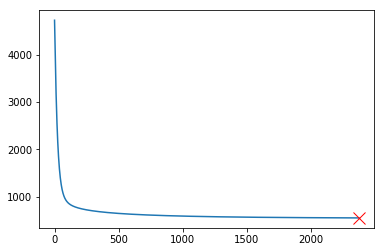

In [10]:
x = np.arange(len(errors))
plt.plot(x, np.array(errors))
idx = np.argmin(errors)
print("BEST ERROR {}".format(errors[idx]))
plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

In [14]:
print(best_error)

0.09573992836807885


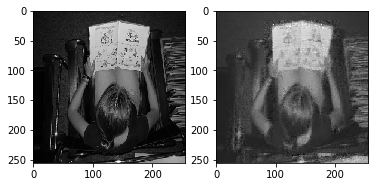

In [11]:
model.eval()
model.set_weights(best_weights)
assert gen_img_path is not None
predict(model, gen_img_path)

In [20]:
model.phase='train'
model = Autoencoder(use_norm=True, use_adapt_lr=False)
model.set_weights(best_weights)
model.lr = 1e-4
momentum = 0.95
epochs = 1
errors=[]
best_weights = None
best_error = np.inf
for epoch in range(epochs):
    moving_err = None
    for it in tqdm(range(dataset_size)):
        inp = next(gen2)
        err = model(inp)
        moving_err = momentum * moving_err + err * (1. - momentum) if moving_err else err
        if moving_err < best_error:
            best_error = moving_err
            best_weights = model.get_weights()
            print("Weights updated {}".format(best_error))
    errors.append(moving_err)
    print("EPOCH {} MSE {}".format(epoch, best_error))


  0%|          | 1/17125 [00:00<1:24:27,  3.38it/s]

Weights updated 0.9788561050719453



  0%|          | 2/17125 [00:00<1:22:52,  3.44it/s]

Weights updated 0.9705370749363286



  0%|          | 6/17125 [00:01<1:22:35,  3.45it/s]

Weights updated 0.9658347922782706



  0%|          | 7/17125 [00:02<1:23:09,  3.43it/s]

Weights updated 0.9505365205274493



  0%|          | 31/17125 [00:08<1:23:10,  3.43it/s]

Weights updated 0.9440655980759869



  0%|          | 32/17125 [00:09<1:23:52,  3.40it/s]

Weights updated 0.9228359174937157



  0%|          | 34/17125 [00:09<1:20:27,  3.54it/s]

Weights updated 0.9177898403411316



  0%|          | 36/17125 [00:10<1:25:49,  3.32it/s]

Weights updated 0.9094267612491557



  0%|          | 38/17125 [00:10<1:25:56,  3.31it/s]

Weights updated 0.8793023027087283



  1%|          | 170/17125 [00:54<1:36:32,  2.93it/s]

KeyboardInterrupt: 

ValueError: attempt to get argmin of an empty sequence

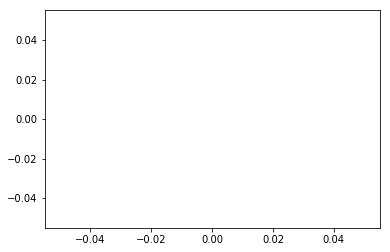

In [14]:
x = np.arange(len(errors))
plt.plot(x, np.array(errors))
idx = np.argmin(errors)
print("BEST ERROR {}".format(errors[idx]))
plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
plt.show()



  0%|          | 0/17125 [00:00<?, ?it/s]

100%|██████████| 17125/17125 [00:00<00:00, 496073.37it/s]

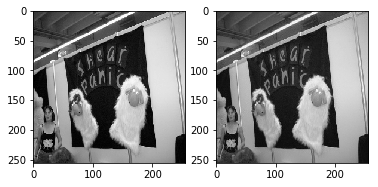

In [29]:
model.eval()
model.set_weights(best_weights)
predict(model)

In [23]:
print(best_weights[0])

[[-0.03764912 -0.09362036  0.0686039  ... -0.0409829   0.02612261
  -0.00917804]
 [ 0.03077989 -0.06825652 -0.10402302 ...  0.02668578  0.12662052
  -0.09181987]
 [-0.03943267  0.03607643 -0.0730328  ...  0.01061164  0.08062493
  -0.10282836]
 ...
 [ 0.04209623 -0.04862455 -0.08263109 ...  0.12985367 -0.00133664
  -0.00706903]
 [-0.06646178  0.01254539 -0.0942494  ...  0.1488274  -0.03263138
   0.08270866]
 [-0.0592315  -0.01431359  0.07801409 ...  0.05576005 -0.09525712
  -0.0246071 ]]


In [28]:
np.save('w1.h5', best_weights[0])
np.save('w2.h5', best_weights[1])